In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')

MIN_LENGTH = 50_000

# Load embeddings (col 0 = length, cols 1-384 = embeddings)
data = np.load('Runs/embeddings_SFE_SE_1.npy')
all_lengths = data[:, 0]
long_mask = all_lengths >= MIN_LENGTH
print(f'Total sequences: {len(all_lengths):,}')
print(f'Sequences >= {MIN_LENGTH:,} bp: {long_mask.sum():,} ({100 * long_mask.mean():.1f}%)')

lengths = all_lengths[long_mask]
embeddings = data[long_mask, 1:]
del data, all_lengths
print(f'Loaded {embeddings.shape[0]:,} embeddings with {embeddings.shape[1]} dimensions')
print(f'Length range: {lengths.min():.0f} - {lengths.max():.0f}')

# Pre-compute L2-normalized embeddings for cosine distance via dot product
norms = np.linalg.norm(embeddings, axis = 1, keepdims = True)
embeddings_normed = embeddings / norms
del norms

# Load embedding IDs (filter to same mask)
all_ids = np.loadtxt('Runs/ids_SFE_SE_1.txt', dtype = str)
embedding_ids = all_ids[long_mask]
del all_ids
print(f'Loaded {embedding_ids.shape[0]:,} embedding IDs')

# Load k-mer frequencies (col 0 = length, cols 1-2772 = k-mers)
kmers = np.load('Runs/kmers_SFE_SE_1.npy')[long_mask]
print(f'Loaded k-mer data: {kmers.shape}')

del long_mask

# Extract k-mer frequencies by size (new format without 7-mers)
six_mers = kmers[:, 1:2081]        # 2080 features
five_mers = kmers[:, 2081:2593]    # 512 features
four_mers = kmers[:, 2593:2729]    # 136 features
three_mers = kmers[:, 2729:2761]   # 32 features
two_mers = kmers[:, 2761:2771]     # 10 features
one_mers = kmers[:, 2771:2773]     # 2 features

print(f'6-mers: {six_mers.shape[1]} features')
print(f'5-mers: {five_mers.shape[1]} features')
print(f'4-mers: {four_mers.shape[1]} features')
print(f'3-mers: {three_mers.shape[1]} features')
print(f'2-mers: {two_mers.shape[1]} features')
print(f'1-mers: {one_mers.shape[1]} features')

Total sequences: 6,693,829
Sequences >= 50,000 bp: 461,674 (6.9%)
Loaded 461,674 embeddings with 384 dimensions
Length range: 50000 - 10208085
Loaded 461,674 embedding IDs
Loaded k-mer data: (461674, 2773)
6-mers: 2080 features
5-mers: 512 features
4-mers: 136 features
3-mers: 32 features
2-mers: 10 features
1-mers: 2 features



Number of pairwise distances: 49,995,000
Distance range: 0.17 - 39.08
Mean: 12.85, Std: 2.27


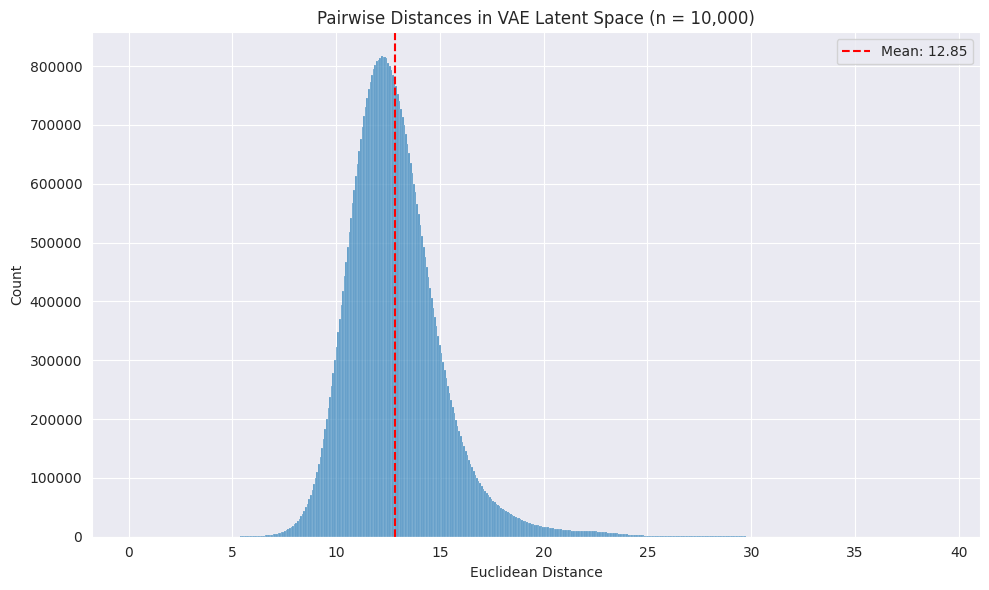

In [2]:
# Randomly sample 10,000 entries
rng = np.random.default_rng(42)
idx = rng.choice(len(embeddings), size = 10_000, replace = False)
sample = embeddings[idx]

# Calculate pairwise Euclidean distances (float32 via squared-distance decomposition)
sq_norms = np.einsum('ij,ij->i', sample, sample)
sq_dists = sq_norms[:, None] + sq_norms[None, :] - 2 * (sample @ sample.T)
np.maximum(sq_dists, 0, out = sq_dists)  # Clamp numerical noise
np.fill_diagonal(sq_dists, 0)
# Extract upper triangle (same as pdist output)
distances = np.sqrt(sq_dists[np.triu_indices(len(sample), k = 1)])

print(f'\nNumber of pairwise distances: {len(distances):,}')
print(f'Distance range: {distances.min():.2f} - {distances.max():.2f}')
print(f'Mean: {distances.mean():.2f}, Std: {distances.std():.2f}')

# Plot histogram
fig, ax = plt.subplots(figsize = (10, 6))
sns.histplot(distances, bins = 500, alpha = 0.7, ax = ax)
ax.axvline(distances.mean(), color = 'red', linestyle = '--', label = f'Mean: {distances.mean():.2f}')
ax.set_xlabel('Euclidean Distance')
ax.set_ylabel('Count')
ax.set_title('Pairwise Distances in VAE Latent Space (n = 10,000)')
ax.legend()
plt.tight_layout()
plt.show()
del sq_norms, sq_dists

Number of pairwise distances: 49,995,000
Distance range: 0.0002 - 1.3734
Mean: 0.9963, Std: 0.0818


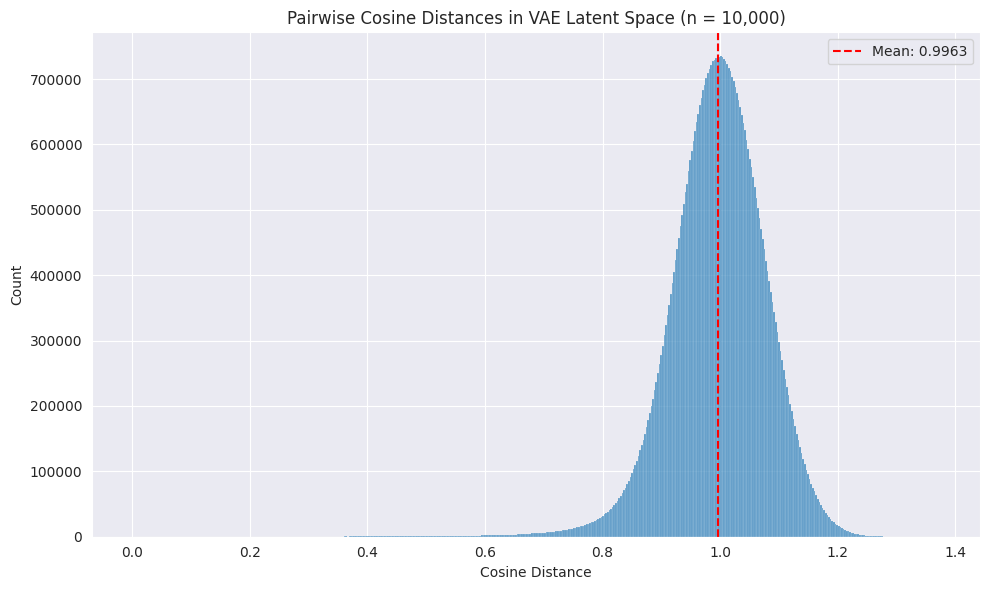

In [3]:
# Calculate pairwise cosine distances (using same sample, float32 via dot product)
sample_norms = np.linalg.norm(sample, axis = 1, keepdims = True)
sample_normed = sample / sample_norms
cos_sims = sample_normed @ sample_normed.T
np.clip(cos_sims, -1, 1, out = cos_sims)
cos_dists = 1 - cos_sims
cosine_distances = cos_dists[np.triu_indices(len(sample), k = 1)]

print(f'Number of pairwise distances: {len(cosine_distances):,}')
print(f'Distance range: {cosine_distances.min():.4f} - {cosine_distances.max():.4f}')
print(f'Mean: {cosine_distances.mean():.4f}, Std: {cosine_distances.std():.4f}')

# Plot histogram
fig, ax = plt.subplots(figsize = (10, 6))
sns.histplot(cosine_distances, bins = 500, alpha = 0.7, ax = ax)
ax.axvline(cosine_distances.mean(), color = 'red', linestyle = '--', label = f'Mean: {cosine_distances.mean():.4f}')
ax.set_xlabel('Cosine Distance')
ax.set_ylabel('Count')
ax.set_title('Pairwise Cosine Distances in VAE Latent Space (n = 10,000)')
ax.legend()
plt.tight_layout()
plt.show()
del sample_normed, cos_sims, cos_dists

Total 6-mer frequency values: 960,281,920
Range: 0.000000 - 0.234482
Mean: 0.000481, Std: 0.000497


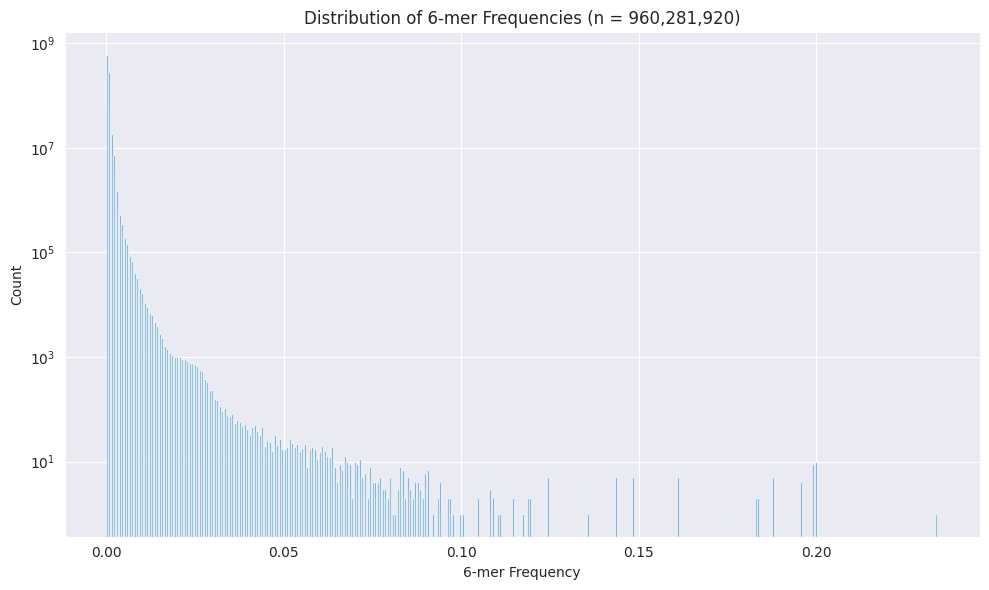

In [4]:
# Analyze 6-mer frequency distribution (using six_mers view, no flatten)
print(f'Total 6-mer frequency values: {six_mers.size:,}')
print(f'Range: {six_mers.min():.6f} - {six_mers.max():.6f}')
print(f'Mean: {six_mers.mean():.6f}, Std: {six_mers.std():.6f}')

# Compute histogram in chunks to avoid 56 GB flatten
bins = np.linspace(six_mers.min(), six_mers.max(), 501)
counts = np.zeros(len(bins) - 1, dtype = np.int64)
chunk_size = 100_000
for start in range(0, len(six_mers), chunk_size):
    chunk = six_mers[start:start + chunk_size].ravel()
    c, _ = np.histogram(chunk, bins = bins)
    counts += c

# Plot histogram
fig, ax = plt.subplots(figsize = (10, 6))
bin_widths = np.diff(bins)
ax.bar(bins[:-1], counts, width = bin_widths, alpha = 0.7, align = 'edge')
ax.set_yscale('log')
ax.set_xlabel('6-mer Frequency')
ax.set_ylabel('Count')
ax.set_title(f'Distribution of 6-mer Frequencies (n = {six_mers.size:,})')
plt.tight_layout()
plt.show()

In [ ]:
## Analyze 6-mer frequency distribution
## How many 6-mers occur less than 1% of the time
#threshold = 0.01
#rare_counts = np.sum(six_mers < threshold, axis = 1)
#
#print(f'6-mer rarity analysis (threshold: {threshold * 100:.0f}%)')
#print(f'Total 6-mers per sequence: {six_mers.shape[1]}')
#print(f'Rare 6-mers per sequence (< {threshold * 100:.0f}%):')
#print(f'  Mean: {rare_counts.mean():.1f}')
#print(f'  Min: {rare_counts.min()}')
#print(f'  Max: {rare_counts.max()}')
#print(f'  Median: {np.median(rare_counts):.0f}')
#
## Plot histogram
#fig, ax = plt.subplots(figsize = (10, 6))
#sns.histplot(rare_counts, bins = 100, alpha = 0.7, ax = ax)
#ax.axvline(rare_counts.mean(), color = 'red', linestyle = '--', label = f'Mean: {rare_counts.mean():.1f}')
#ax.set_xlabel(f'Number of 6-mers with frequency < {threshold * 100:.0f}%')
#ax.set_ylabel('Count (sequences)')
#ax.set_title(f'Distribution of Rare 6-mer Counts (n = {len(rare_counts):,})')
#ax.legend()
#plt.tight_layout()
#plt.show()

Sampled 100,000 sequences
Sequences with at least one neighbor within 5.0 Euclidean distance: 35,221 (35.22%)
Minimum distance found: 0.0438
Mean nearest neighbor distance: 5.9242


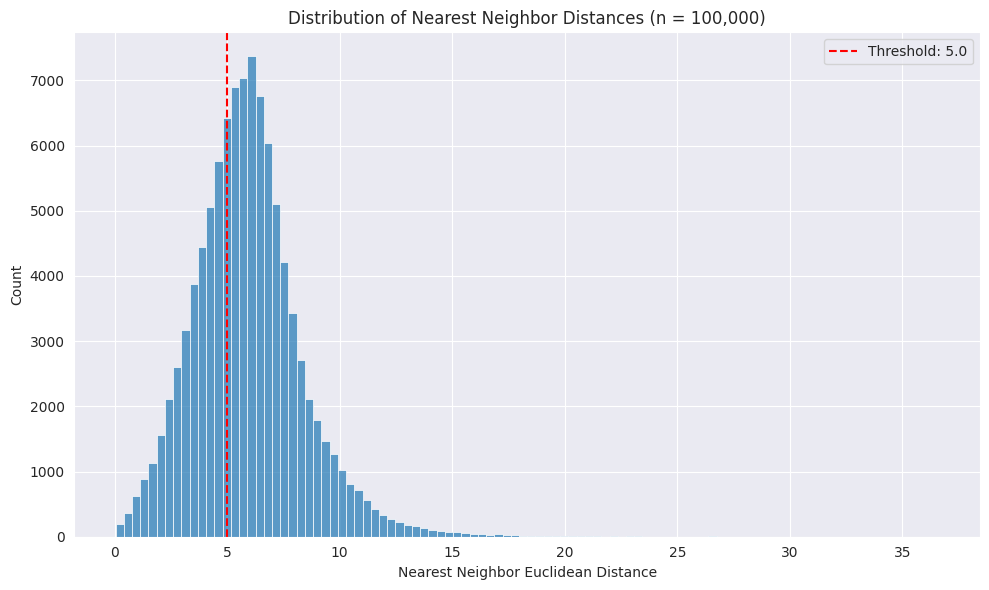

In [5]:
# Sample 100,000 sequences and check for close neighbors (float32 Euclidean)
sample_size = 100_000
neighbor_threshold = 5.0

rng_sample = np.random.default_rng(123)
sample_idx = rng_sample.choice(len(embeddings), size = sample_size, replace = False)
sample_embeddings = embeddings[sample_idx]

# Pre-compute squared norms for ||a-b||² = ||a||² + ||b||² - 2·a·b
sq_norms = np.einsum('ij,ij->i', sample_embeddings, sample_embeddings)

# Compute nearest-neighbor distances in chunks (~2 GB per chunk in float32)
min_distances = np.full(sample_size, np.inf, dtype = np.float32)
chunk_size = 5_000
for start in range(0, sample_size, chunk_size):
    end = min(start + chunk_size, sample_size)
    # Squared Euclidean distances
    sq_dists = sq_norms[start:end, None] + sq_norms[None, :] - 2 * (sample_embeddings[start:end] @ sample_embeddings.T)
    np.maximum(sq_dists, 0, out = sq_dists)
    # Set self-distances to inf
    for i in range(end - start):
        sq_dists[i, start + i] = np.inf
    min_distances[start:end] = np.sqrt(sq_dists.min(axis = 1))
    del sq_dists

has_close_neighbor = min_distances < neighbor_threshold

print(f'Sampled {sample_size:,} sequences')
print(f'Sequences with at least one neighbor within {neighbor_threshold} Euclidean distance: {has_close_neighbor.sum():,} ({100 * has_close_neighbor.mean():.2f}%)')
print(f'Minimum distance found: {min_distances.min():.4f}')
print(f'Mean nearest neighbor distance: {min_distances.mean():.4f}')

# Plot histogram of minimum distances
fig, ax = plt.subplots(figsize = (10, 6))
sns.histplot(min_distances, bins = 100, alpha = 0.7, ax = ax)
ax.axvline(neighbor_threshold, color = 'red', linestyle = '--', label = f'Threshold: {neighbor_threshold}')
ax.set_xlabel('Nearest Neighbor Euclidean Distance')
ax.set_ylabel('Count')
ax.set_title(f'Distribution of Nearest Neighbor Distances (n = {sample_size:,})')
ax.legend()
plt.tight_layout()
plt.show()

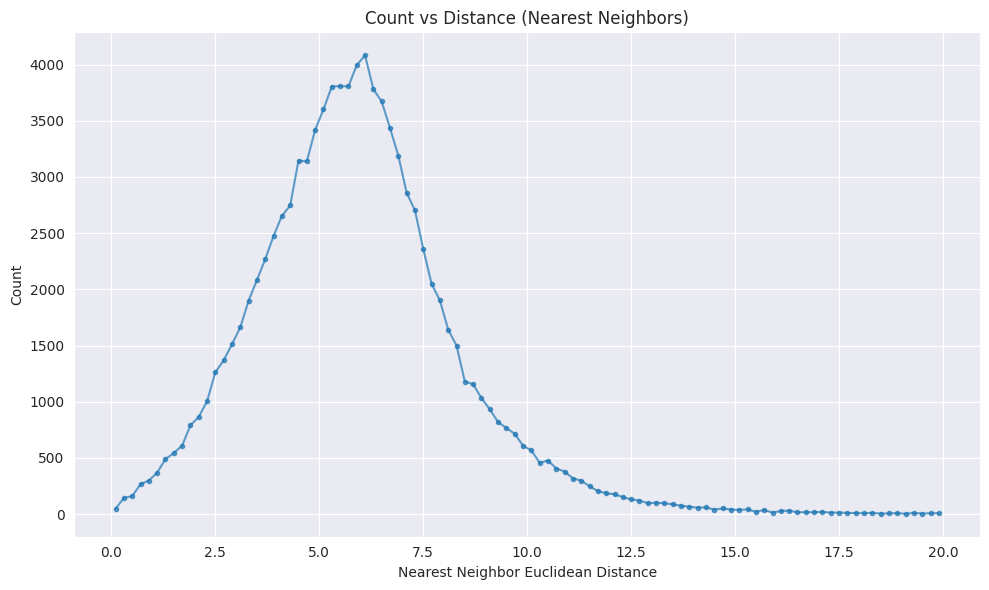

Linear fit: count = -122.6 * distance + 2225.5
R² = 0.3161


In [6]:
# Plot count vs distance (binned)
max_dist = 20.0
bins = np.linspace(0, max_dist, 101)
bin_centers = (bins[:-1] + bins[1:]) / 2
counts, _ = np.histogram(min_distances[min_distances < max_dist], bins = bins)

fig, ax = plt.subplots(figsize = (10, 6))
ax.plot(bin_centers, counts, 'o-', markersize = 3, alpha = 0.7)
ax.set_xlabel('Nearest Neighbor Euclidean Distance')
ax.set_ylabel('Count')
ax.set_title('Count vs Distance (Nearest Neighbors)')
plt.tight_layout()
plt.show()

# Fit a linear regression
from scipy.stats import linregress
slope, intercept, r_value, p_value, std_err = linregress(bin_centers, counts)
print(f'Linear fit: count = {slope:.1f} * distance + {intercept:.1f}')
print(f'R² = {r_value**2:.4f}')

TWO-NN intrinsic dimensionality estimate: d̂ = 4.42
Valid μ values: 100,000 / 100,000
μ range: 1.000001 - 204.632738, mean: 1.213407


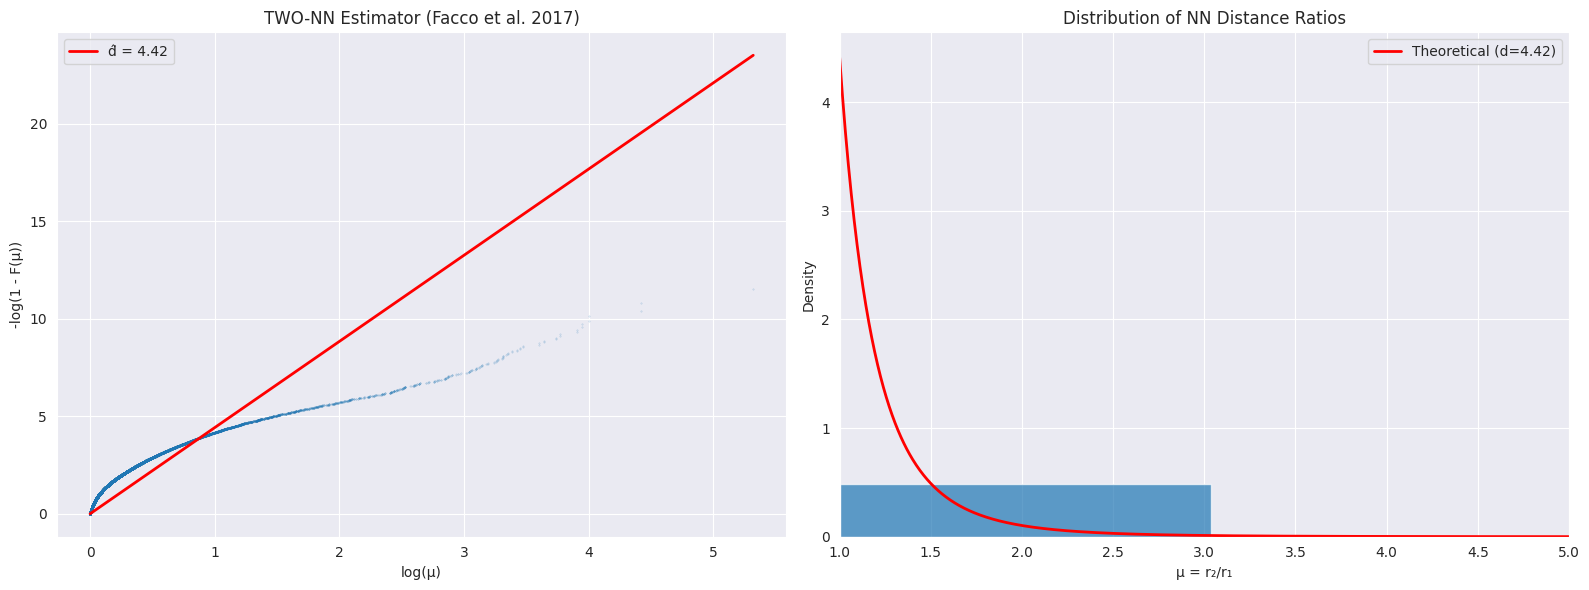

In [7]:
# TWO-NN intrinsic dimensionality estimator (Facco et al. 2017)
# Uses sample_embeddings from cell 8

# Cast to float64 for distance precision (100K × 384 = ~300 MB)
sample_f64 = sample_embeddings.astype(np.float64)
sq_norms_f64 = np.einsum('ij,ij->i', sample_f64, sample_f64)

# Find two nearest neighbors per point in chunks (~4 GB per chunk in float64)
n_sample = len(sample_f64)
nn1 = np.full(n_sample, np.inf)
nn2 = np.full(n_sample, np.inf)
chunk_size = 5_000
for start in range(0, n_sample, chunk_size):
    end = min(start + chunk_size, n_sample)
    sq_dists = sq_norms_f64[start:end, None] + sq_norms_f64[None, :] - 2 * (sample_f64[start:end] @ sample_f64.T)
    np.maximum(sq_dists, 0, out = sq_dists)
    # Set self-distances to inf
    for i in range(end - start):
        sq_dists[i, start + i] = np.inf
    # Two smallest squared distances per row
    top2_sq = np.partition(sq_dists, 1, axis = 1)[:, :2]
    top2_sq.sort(axis = 1)
    nn1[start:end] = np.sqrt(top2_sq[:, 0])
    nn2[start:end] = np.sqrt(top2_sq[:, 1])
    del sq_dists, top2_sq

del sample_f64, sq_norms_f64

# Compute μ = r₂/r₁
mu = nn2 / nn1
valid = np.isfinite(mu) & (mu > 1)
mu = np.sort(mu[valid])

# Empirical CDF
n = len(mu)
F_emp = np.arange(1, n + 1) / n

# Fit: from F(μ) = 1 - μ^(-d), we get -log(1 - F) = d * log(μ)
# Slope through origin = d̂
x = np.log(mu[:-1])  # exclude last point where F_emp = 1
y = -np.log(1 - F_emp[:-1])
d_hat = np.sum(x * y) / np.sum(x * x)

print(f'TWO-NN intrinsic dimensionality estimate: d̂ = {d_hat:.2f}')
print(f'Valid μ values: {n:,} / {n_sample:,}')
print(f'μ range: {mu.min():.6f} - {mu.max():.6f}, mean: {mu.mean():.6f}')

# Plot
fig, axes = plt.subplots(1, 2, figsize = (16, 6))

# Left: log(μ) vs -log(1-F) with fitted line
axes[0].scatter(x, y, s = 0.1, alpha = 0.3)
x_fit = np.linspace(0, x.max(), 100)
axes[0].plot(x_fit, d_hat * x_fit, 'r-', linewidth = 2, label = f'd̂ = {d_hat:.2f}')
axes[0].set_xlabel('log(μ)')
axes[0].set_ylabel('-log(1 - F(μ))')
axes[0].set_title('TWO-NN Estimator (Facco et al. 2017)')
axes[0].legend()

# Right: histogram of μ with theoretical PDF f(μ) = d * μ^(-(d+1))
axes[1].hist(mu, bins = 100, alpha = 0.7, density = True)
mu_theory = np.linspace(1, min(5, mu.max()), 1000)
pdf_theory = d_hat * mu_theory ** (-(d_hat + 1))
axes[1].plot(mu_theory, pdf_theory, 'r-', linewidth = 2, label = f'Theoretical (d={d_hat:.2f})')
axes[1].set_xlabel('μ = r₂/r₁')
axes[1].set_ylabel('Density')
axes[1].set_title('Distribution of NN Distance Ratios')
axes[1].legend()
axes[1].set_xlim(1, min(5, mu.max()))

plt.tight_layout()
plt.show()

In [8]:
# t-SNE visualization using openTSNE (full dataset)
from openTSNE import TSNE

# Use all embeddings
tsne_sample_size = len(embeddings)
tsne_idx = np.arange(tsne_sample_size)
tsne_embeddings = embeddings
tsne_ids = embedding_ids
tsne_lengths = lengths

print(f'Using all {tsne_sample_size:,} embeddings for t-SNE')
print(f'Running t-SNE (this may take a while)...')

# Run t-SNE with Euclidean metric (better for this VAE than cosine)
tsne = TSNE(
    n_components = 2,
    perplexity = 30,
    metric = 'euclidean',
    n_jobs = -1,  # Use all cores
    random_state = 42,
    verbose = True
)
tsne_result = tsne.fit(tsne_embeddings)

print(f't-SNE complete. Result shape: {tsne_result.shape}')

Using all 461,674 embeddings for t-SNE
Running t-SNE (this may take a while)...
--------------------------------------------------------------------------------
TSNE(early_exaggeration=12, n_jobs=-1, random_state=42, verbose=True)
--------------------------------------------------------------------------------
===> Finding 90 nearest neighbors using Annoy approximate search using euclidean distance...
   --> Time elapsed: 41.20 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 6.99 seconds
===> Calculating PCA-based initialization...
   --> Time elapsed: 0.83 seconds
===> Running optimization with exaggeration=12.00, lr=38472.83 for 250 iterations...
Iteration   50, KL divergence 7.4079, 50 iterations in 4.8738 sec
Iteration  100, KL divergence 6.7559, 50 iterations in 5.0103 sec
Iteration  150, KL divergence 6.4446, 50 iterations in 5.0589 sec
Iteration  200, KL divergence 6.2503, 50 iterations in 4.9209 sec
Iteration  250, KL divergence 6.1112, 50 iterations in 5.0582 

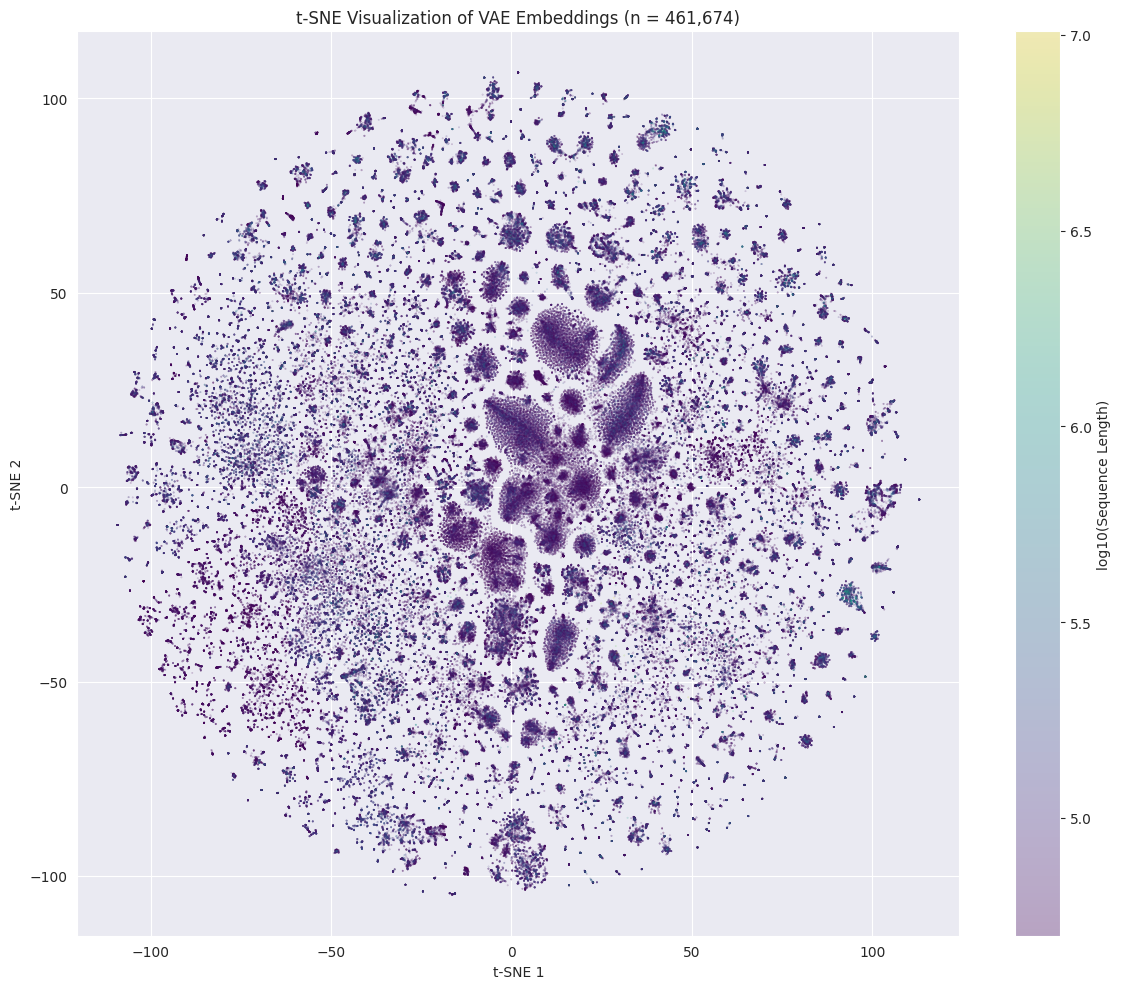

In [9]:
# Plot t-SNE result
fig, ax = plt.subplots(figsize = (12, 10))

# Use scatter with small alpha for 1M points
scatter = ax.scatter(
    tsne_result[:, 0],
    tsne_result[:, 1],
    c = np.log10(tsne_lengths),  # Color by log sequence length
    cmap = 'viridis',
    s = 0.1,
    alpha = 0.3
)
cbar = plt.colorbar(scatter, ax = ax)
cbar.set_label('log10(Sequence Length)')

ax.set_xlabel('t-SNE 1')
ax.set_ylabel('t-SNE 2')
ax.set_title(f't-SNE Visualization of VAE Embeddings (n = {tsne_sample_size:,})')
plt.tight_layout()
plt.show()

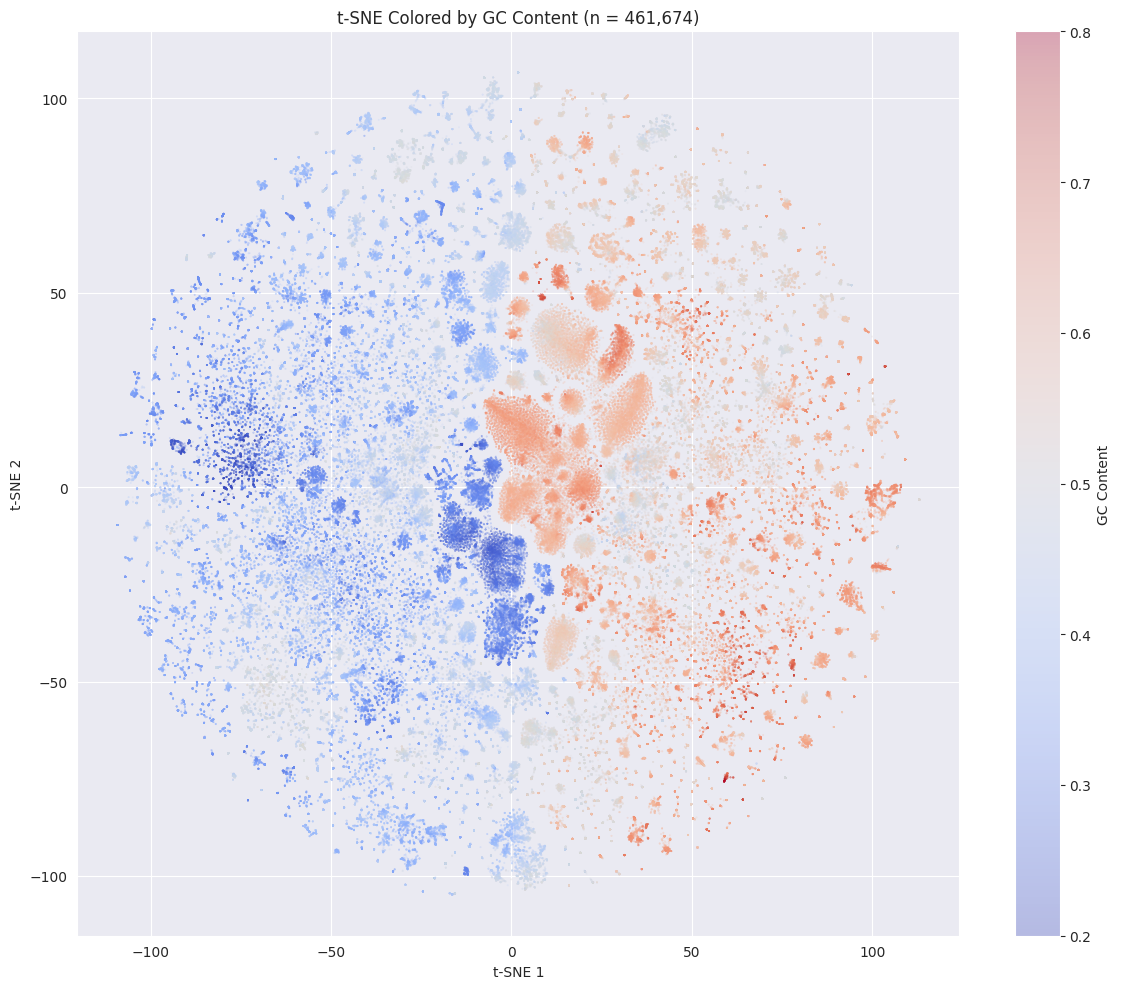

GC content range: 0.138 - 0.839
GC content mean: 0.474


In [10]:
# Plot t-SNE colored by GC content (last column of kmers)
gc_content = kmers[tsne_idx, -1]

fig, ax = plt.subplots(figsize = (12, 10))
scatter = ax.scatter(
    tsne_result[:, 0],
    tsne_result[:, 1],
    c = gc_content,
    cmap = 'coolwarm',
    s = 0.1,
    alpha = 0.3,
    vmin = 0.2,
    vmax = 0.8
)
cbar = plt.colorbar(scatter, ax = ax)
cbar.set_label('GC Content')

ax.set_xlabel('t-SNE 1')
ax.set_ylabel('t-SNE 2')
ax.set_title(f't-SNE Colored by GC Content (n = {tsne_sample_size:,})')
plt.tight_layout()
plt.show()

print(f'GC content range: {gc_content.min():.3f} - {gc_content.max():.3f}')
print(f'GC content mean: {gc_content.mean():.3f}')

SFE sequences: 232,692 (50.4%)
SE sequences: 228,982 (49.6%)


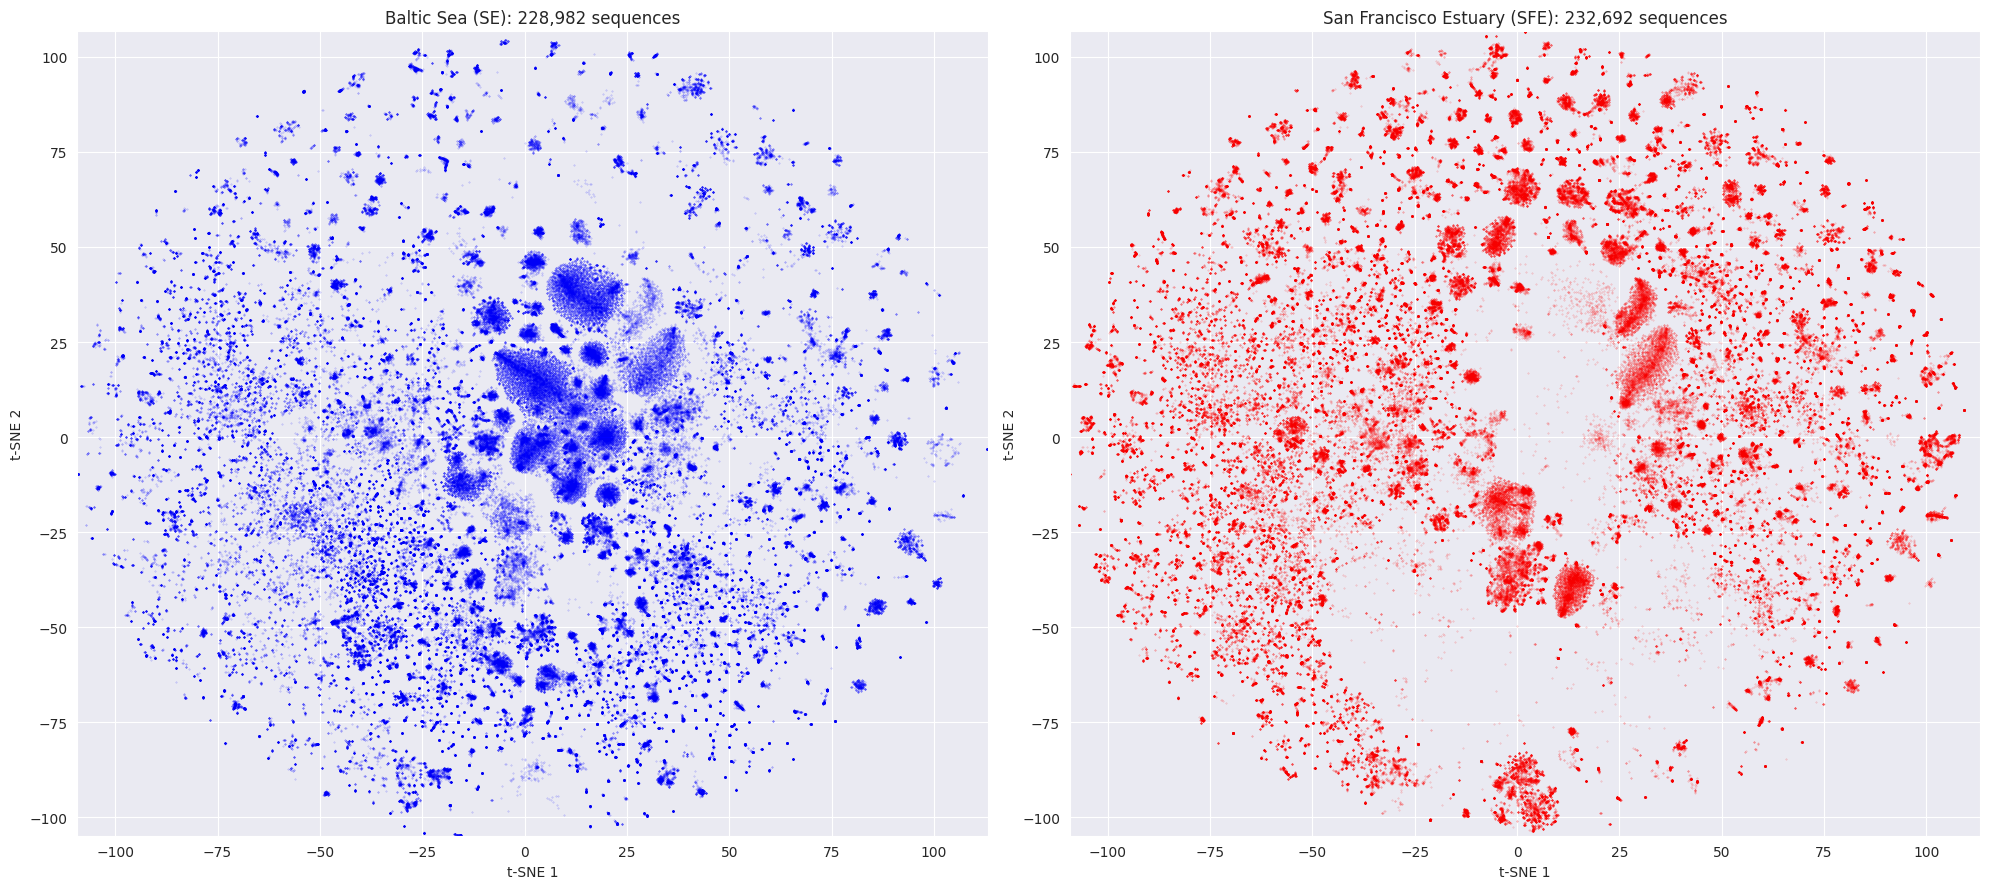

In [11]:
# Plot t-SNE colored by ID prefix (SFE vs SE) - side by side
is_sfe = np.array([id.startswith('SFE') for id in tsne_ids])
is_se = np.array([id.startswith('SE') for id in tsne_ids])

print(f'SFE sequences: {is_sfe.sum():,} ({100 * is_sfe.mean():.1f}%)')
print(f'SE sequences: {is_se.sum():,} ({100 * is_se.mean():.1f}%)')

fig, axes = plt.subplots(1, 2, figsize = (20, 9))

# Left: SE only (Baltic)
axes[0].scatter(
    tsne_result[is_se, 0],
    tsne_result[is_se, 1],
    c = 'blue',
    s = 0.1,
    alpha = 0.3
)
axes[0].set_xlabel('t-SNE 1')
axes[0].set_ylabel('t-SNE 2')
axes[0].set_title(f'Baltic Sea (SE): {is_se.sum():,} sequences')

# Right: SFE only (San Francisco Estuary)
axes[1].scatter(
    tsne_result[is_sfe, 0],
    tsne_result[is_sfe, 1],
    c = 'red',
    s = 0.1,
    alpha = 0.3
)
axes[1].set_xlabel('t-SNE 1')
axes[1].set_ylabel('t-SNE 2')
axes[1].set_title(f'San Francisco Estuary (SFE): {is_sfe.sum():,} sequences')

# Match axis limits so they're comparable
xlim = (tsne_result[:, 0].min(), tsne_result[:, 0].max())
ylim = (tsne_result[:, 1].min(), tsne_result[:, 1].max())
for ax in axes:
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

plt.tight_layout()
plt.show()

Running HDBSCAN on 461,674 points...


/home/torben/Embedding/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/torben/Embedding/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Clusters found: 1171
Noise points: 85,989 (18.6%)


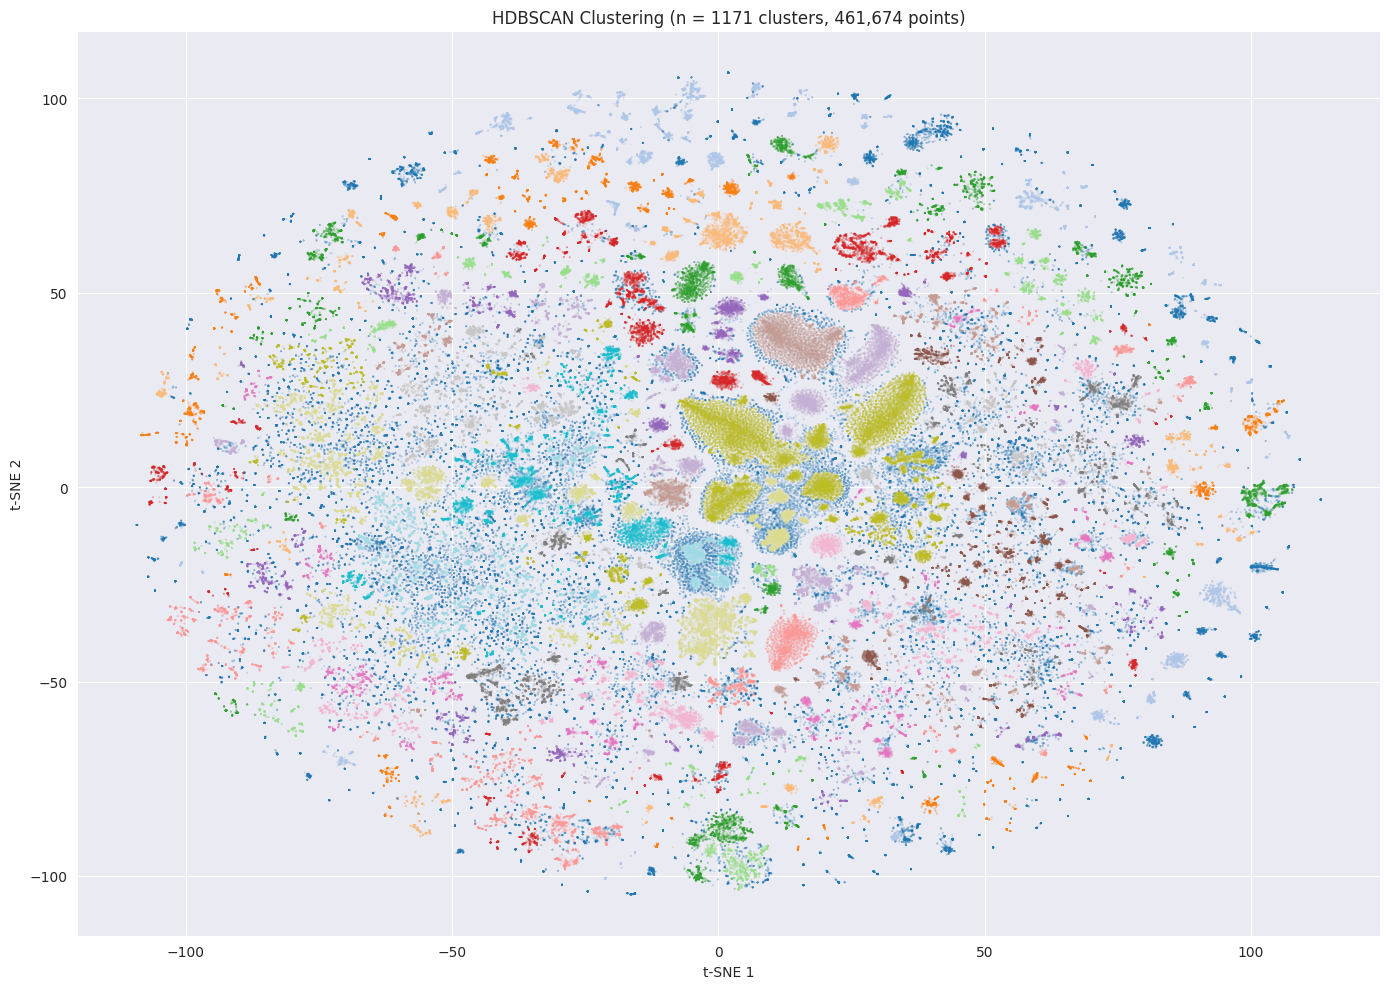

In [12]:
# HDBSCAN clustering on full t-SNE coordinates
from hdbscan import HDBSCAN

print(f'Running HDBSCAN on {len(tsne_result):,} points...')
clusterer = HDBSCAN(min_cluster_size = 100, min_samples = 50)
labels = clusterer.fit_predict(tsne_result)

n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise = (labels == -1).sum()

print(f'Clusters found: {n_clusters}')
print(f'Noise points: {n_noise:,} ({100 * n_noise / len(labels):.1f}%)')

# Plot with cluster colors
fig, ax = plt.subplots(figsize = (14, 10))
scatter = ax.scatter(
    tsne_result[:, 0],
    tsne_result[:, 1],
    c = labels,
    cmap = 'tab20',
    s = 0.1,
    alpha = 0.3
)
ax.set_xlabel('t-SNE 1')
ax.set_ylabel('t-SNE 2')
ax.set_title(f'HDBSCAN Clustering (n = {n_clusters} clusters, {len(tsne_result):,} points)')
plt.tight_layout()
plt.show()

In [13]:
# List clusters and save to files
unique_labels = sorted(set(labels) - {-1})  # Exclude noise

# Save cluster sizes to clusters.tsv
with open('clusters.tsv', 'w') as f:
    f.write('cluster\tsize\n')
    for label in unique_labels:
        size = (labels == label).sum()
        f.write(f'{label}\t{size}\n')
    f.write(f'noise\t{(labels == -1).sum()}\n')

print(f'Saved cluster sizes to clusters.tsv')

# Save cluster memberships to cluster_members.tsv
with open('cluster_members.tsv', 'w') as f:
    f.write('cluster\tsequence_ids\n')
    for label in unique_labels:
        mask = labels == label
        ids = embedding_ids[mask]
        f.write(f'{label}\t{",".join(ids)}\n')

print(f'Saved cluster memberships to cluster_members.tsv')

Saved cluster sizes to clusters.tsv
Saved cluster memberships to cluster_members.tsv


In [13]:
# Phase 1: Distance landscape from kNN graph
# Parse nn1, nn2, and nn50 distances from neighbors TSV

tsv_path = 'Runs/neighbors_SFE_SE_050.tsv'
n_sequences = len(embeddings)

nn1_dists = np.empty(n_sequences, dtype = np.float32)
nn2_dists = np.empty(n_sequences, dtype = np.float32)
nn50_dists = np.empty(n_sequences, dtype = np.float32)

with open(tsv_path, 'r') as f:
    for i, line in enumerate(f):
        fields = line.rstrip('\n').split('\t')
        nn1_dists[i] = float(fields[1].split('(')[1].rstrip(')'))
        nn2_dists[i] = float(fields[2].split('(')[1].rstrip(')'))
        nn50_dists[i] = float(fields[-1].split('(')[1].rstrip(')'))
        if (i + 1) % 1_000_000 == 0:
            print(f'Parsed {i + 1:,} / {n_sequences:,} lines...')

print(f'\nParsed all {n_sequences:,} lines')
print(f'nn1  range: {nn1_dists.min():.4f} - {nn1_dists.max():.4f}, mean: {nn1_dists.mean():.4f}, median: {np.median(nn1_dists):.4f}')
print(f'nn2  range: {nn2_dists.min():.4f} - {nn2_dists.max():.4f}, mean: {nn2_dists.mean():.4f}, median: {np.median(nn2_dists):.4f}')
print(f'nn50 range: {nn50_dists.min():.4f} - {nn50_dists.max():.4f}, mean: {nn50_dists.mean():.4f}, median: {np.median(nn50_dists):.4f}')

# Percentiles
for p in [1, 5, 10, 25, 50, 75, 90, 95, 99]:
    print(f'nn1 P{p:2d}: {np.percentile(nn1_dists, p):.4f}    nn50 P{p:2d}: {np.percentile(nn50_dists, p):.4f}')


Parsed all 461,674 lines
nn1  range: 0.0000 - 40.6269, mean: 5.2843, median: 5.0079
nn2  range: 0.0413 - 40.7006, mean: 5.8399, median: 5.5854
nn50 range: 1.6626 - 40.9110, mean: 7.7429, median: 7.3714
nn1 P 1: 0.6469    nn50 P 1: 3.6163
nn1 P 5: 1.5397    nn50 P 5: 4.5478
nn1 P10: 2.2071    nn50 P10: 5.1272
nn1 P25: 3.4805    nn50 P25: 6.1679
nn1 P50: 5.0079    nn50 P50: 7.3714
nn1 P75: 6.6222    nn50 P75: 8.9267
nn1 P90: 8.5807    nn50 P90: 10.7522
nn1 P95: 10.1015    nn50 P95: 11.9761
nn1 P99: 13.4797    nn50 P99: 15.4441


Parsed all 461,674 sequences, 50 neighbors each


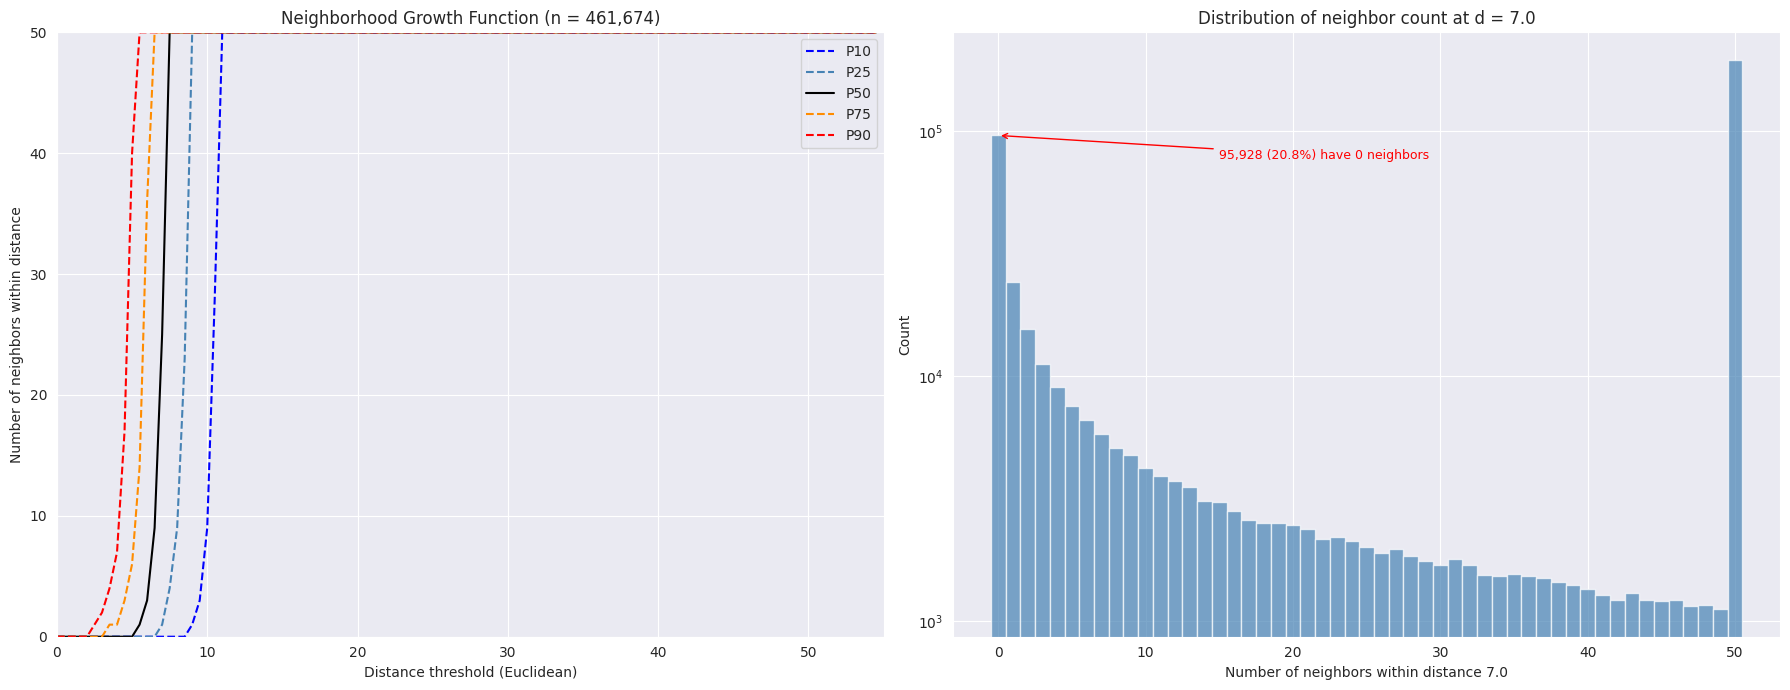


Neighbors within distance d (percentiles across 461,674 sequences):
     d    P10    P25    P50    P75    P90    Mean
     2      0      0      0      0      0     0.2
     3      0      0      0      0      2     0.9
     4      0      0      0      1      7     3.1
     5      0      0      0      6     40     7.9
     6      0      0      3     36     50    15.9
     7      0      1     25     50     50    26.3
     8      0      9     50     50     50    34.7
    10      9     50     50     50     50    44.0
    12     50     50     50     50     50    47.9
    15     50     50     50     50     50    49.5
    20     50     50     50     50     50    49.9


In [14]:
# Neighborhood growth: how many neighbors within distance d?
# Parse all 50 neighbor distances for ALL sequences

tsv_path = 'Runs/neighbors_SFE_SE_050.tsv'
n_sequences = len(embeddings)

# Distance thresholds to evaluate
d_thresholds = np.arange(0, 55, 0.5)
n_thresholds = len(d_thresholds)

# For each sequence, count neighbors within each distance threshold
counts = np.zeros((n_sequences, n_thresholds), dtype = np.int16)

with open(tsv_path, 'r') as f:
    for i, line in enumerate(f):
        fields = line.rstrip('\n').split('\t')
        dists = np.empty(len(fields) - 1, dtype = np.float32)
        for j, field in enumerate(fields[1:]):
            paren = field.rfind('(')
            dists[j] = float(field[paren + 1:-1])
        # Vectorized: count neighbors within each threshold
        counts[i] = np.searchsorted(dists, d_thresholds, side = 'right')
        if (i + 1) % 1_000_000 == 0:
            print(f'Parsed {i + 1:,} / {n_sequences:,}...')

print(f'Parsed all {n_sequences:,} sequences, {len(dists)} neighbors each')

# Plot percentile curves
fig, axes = plt.subplots(1, 2, figsize = (18, 7))

# Left: percentile curves of N(d)
for p, color, ls in [(10, 'blue', '--'), (25, 'steelblue', '--'),
                      (50, 'black', '-'), (75, 'darkorange', '--'),
                      (90, 'red', '--')]:
    pct = np.percentile(counts, p, axis = 0)
    axes[0].plot(d_thresholds, pct, color = color, linestyle = ls, linewidth = 1.5,
                 label = f'P{p}')
axes[0].set_xlabel('Distance threshold (Euclidean)')
axes[0].set_ylabel('Number of neighbors within distance')
axes[0].set_title(f'Neighborhood Growth Function (n = {n_sequences:,})')
axes[0].legend()
axes[0].set_xlim(0, 55)
axes[0].set_ylim(0, 50)

# Right: histogram of neighbors within distance 7
d_cutoff = 7.0
d_idx = np.argmin(np.abs(d_thresholds - d_cutoff))
n_within = counts[:, d_idx]
axes[1].hist(n_within, bins = np.arange(-0.5, 51.5, 1), alpha = 0.7, color = 'steelblue')
axes[1].set_yscale('log')
axes[1].set_xlabel(f'Number of neighbors within distance {d_cutoff}')
axes[1].set_ylabel('Count')
axes[1].set_title(f'Distribution of neighbor count at d = {d_cutoff}')
# Annotate
n_zero = (n_within == 0).sum()
axes[1].annotate(f'{n_zero:,} ({100 * n_zero / n_sequences:.1f}%) have 0 neighbors',
                 xy = (0, n_zero), fontsize = 9, color = 'red',
                 xytext = (15, n_zero * 0.8), arrowprops = dict(arrowstyle = '->', color = 'red'))

plt.tight_layout()
plt.show()

# Print stats at key thresholds
print(f'\nNeighbors within distance d (percentiles across {n_sequences:,} sequences):')
print(f'{"d":>6s}  {"P10":>5s}  {"P25":>5s}  {"P50":>5s}  {"P75":>5s}  {"P90":>5s}  {"Mean":>6s}')
for d in [2, 3, 4, 5, 6, 7, 8, 10, 12, 15, 20]:
    d_idx = np.argmin(np.abs(d_thresholds - d))
    col = counts[:, d_idx]
    print(f'{d:6.0f}  {np.percentile(col, 10):5.0f}  {np.percentile(col, 25):5.0f}  '
          f'{np.percentile(col, 50):5.0f}  {np.percentile(col, 75):5.0f}  '
          f'{np.percentile(col, 90):5.0f}  {col.mean():6.1f}')

In [15]:
# Distance-threshold clustering: connect sequences within d < 7
# Edges weighted by 1/(distance + epsilon) so Leiden prefers cutting distant edges
import igraph as ig
import leidenalg

d_threshold = 7.0
epsilon = 0.1
tsv_path = 'Runs/neighbors_SFE_SE_050.tsv'
n_sequences = len(embeddings)

# Build ID -> index mapping
id_to_idx = {id_: i for i, id_ in enumerate(embedding_ids)}

# Parse neighbors TSV, collect edges with distance < threshold
print(f'Building edge list with d < {d_threshold}, weights = 1/(d + {epsilon})...')
edges = []
weights = []

with open(tsv_path, 'r') as f:
    for i, line in enumerate(f):
        fields = line.rstrip('\n').split('\t')
        for field in fields[1:]:
            paren = field.rfind('(')
            dist = float(field[paren + 1:-1])
            if dist >= d_threshold:
                break  # distance-sorted
            j = id_to_idx[field[:paren]]
            edges.append((i, j))
            weights.append(1.0 / (dist + epsilon))
        if (i + 1) % 1_000_000 == 0:
            print(f'  Parsed {i + 1:,} / {n_sequences:,}... ({len(edges):,} edges so far)')

print(f'\nTotal directed edges: {len(edges):,}')

# Build igraph graph
print('Building igraph graph...')
g = ig.Graph(n = n_sequences, edges = edges, directed = True)
g.es['weight'] = weights
del edges, weights

# When collapsing to undirected, combine weights by max (keep strongest connection)
g = g.as_undirected(mode = 'collapse', combine_edges = {'weight': 'max'})
print(f'Graph: {g.vcount():,} vertices, {g.ecount():,} edges')
w = np.array(g.es['weight'])
print(f'Weight range: {w.min():.4f} - {w.max():.4f}, mean: {w.mean():.4f}')

# Run Leiden with weights
print(f'Running Leiden (resolution=1.0, weighted)...')
partition = leidenalg.find_partition(g, leidenalg.RBConfigurationVertexPartition,
                                     weights = 'weight', n_iterations = -1)
del g

component_labels = np.array(partition.membership)
component_sizes = np.bincount(component_labels)
n_components = len(component_sizes)
n_singletons = (component_sizes == 1).sum()
nonsingleton_sizes = np.sort(component_sizes[component_sizes > 1])[::-1]
n_clustered = component_sizes[component_sizes > 1].sum()

print(f'\n{"=" * 60}')
print(f'Leiden on distance-threshold graph (d < {d_threshold}, weighted)')
print(f'{"=" * 60}')
print(f'Quality (modularity): {partition.quality():.4f}')
print(f'Total communities: {n_components:,}')
print(f'Singletons: {n_singletons:,} ({100 * n_singletons / n_sequences:.1f}%)')
print(f'Non-singleton communities: {len(nonsingleton_sizes):,}')
print(f'Clustered sequences: {n_clustered:,} ({100 * n_clustered / n_sequences:.1f}%)')
if len(nonsingleton_sizes) > 0:
    print(f'  Size range: {nonsingleton_sizes[-1]:,} - {nonsingleton_sizes[0]:,}')
    print(f'  Mean size: {nonsingleton_sizes.mean():.1f}')
    print(f'  Median size: {np.median(nonsingleton_sizes):.0f}')

print(f'\nTop 20 communities:')
for rank, size in enumerate(nonsingleton_sizes[:20]):
    print(f'  {rank + 1:3d}. {size:,} sequences')

Building edge list with d < 7.0, weights = 1/(d + 0.1)...

Total directed edges: 12,121,017
Building igraph graph...
Graph: 461,674 vertices, 9,909,223 edges
Weight range: 0.1408 - 10.0000, mean: 0.1860
Running Leiden (resolution=1.0, weighted)...

Leiden on distance-threshold graph (d < 7.0, weighted)
Quality (modularity): 3618065.7482
Total communities: 96,819
Singletons: 86,503 (18.7%)
Non-singleton communities: 10,316
Clustered sequences: 375,171 (81.3%)
  Size range: 2 - 17,280
  Mean size: 36.4
  Median size: 3

Top 20 communities:
    1. 17,280 sequences
    2. 11,785 sequences
    3. 5,959 sequences
    4. 5,554 sequences
    5. 5,506 sequences
    6. 4,780 sequences
    7. 4,777 sequences
    8. 4,425 sequences
    9. 4,356 sequences
   10. 4,317 sequences
   11. 3,945 sequences
   12. 3,908 sequences
   13. 3,872 sequences
   14. 3,525 sequences
   15. 3,199 sequences
   16. 3,138 sequences
   17. 3,060 sequences
   18. 2,970 sequences
   19. 2,903 sequences
   20. 2,891 sequ

In [16]:
# Mutual kNN Leiden: keep only edges where both directions exist
# Edges weighted by 1/(distance + epsilon), undirected via max
import igraph as ig
import leidenalg

d_threshold = 7.0
epsilon = 0.1
tsv_path = 'Runs/neighbors_SFE_SE_050.tsv'
n_sequences = len(embeddings)

id_to_idx = {id_: i for i, id_ in enumerate(embedding_ids)}

# Parse directed edges
print(f'Building mutual kNN edge list with d < {d_threshold}...')
directed = set()
edge_dists = {}

with open(tsv_path, 'r') as f:
    for i, line in enumerate(f):
        fields = line.rstrip('\n').split('\t')
        for field in fields[1:]:
            paren = field.rfind('(')
            dist = float(field[paren + 1:-1])
            if dist >= d_threshold:
                break
            j = id_to_idx[field[:paren]]
            directed.add((i, j))
            edge_dists[(i, j)] = dist
        if (i + 1) % 1_000_000 == 0:
            print(f'  Parsed {i + 1:,} / {n_sequences:,}...')

print(f'Directed edges: {len(directed):,}')

# Keep only mutual edges
edges = []
weights = []
for (i, j) in directed:
    if i < j and (j, i) in directed:
        d_ij = edge_dists[(i, j)]
        d_ji = edge_dists[(j, i)]
        edges.append((i, j))
        weights.append(1.0 / (max(d_ij, d_ji) + epsilon))

del directed, edge_dists
print(f'Mutual edges: {len(edges):,}')

# Build graph and run Leiden
g = ig.Graph(n = n_sequences, edges = edges, directed = False)
g.es['weight'] = weights
del edges, weights
print(f'Graph: {g.vcount():,} vertices, {g.ecount():,} edges')

print(f'Running Leiden (resolution=1.0, weighted)...')
partition = leidenalg.find_partition(g, leidenalg.RBConfigurationVertexPartition,
                                     weights = 'weight', n_iterations = -1)
del g

mutual_labels = np.array(partition.membership)
mutual_sizes = np.bincount(mutual_labels)
n_components = len(mutual_sizes)
n_singletons = (mutual_sizes == 1).sum()
nonsingleton_sizes = np.sort(mutual_sizes[mutual_sizes > 1])[::-1]
n_clustered = mutual_sizes[mutual_sizes > 1].sum()

print(f'\n{"=" * 60}')
print(f'Mutual kNN Leiden (d < {d_threshold}, weighted)')
print(f'{"=" * 60}')
print(f'Quality (modularity): {partition.quality():.4f}')
print(f'Total communities: {n_components:,}')
print(f'Singletons: {n_singletons:,} ({100 * n_singletons / n_sequences:.1f}%)')
print(f'Non-singleton communities: {len(nonsingleton_sizes):,}')
print(f'Clustered sequences: {n_clustered:,} ({100 * n_clustered / n_sequences:.1f}%)')
if len(nonsingleton_sizes) > 0:
    print(f'  Size range: {nonsingleton_sizes[-1]:,} - {nonsingleton_sizes[0]:,}')
    print(f'  Mean size: {nonsingleton_sizes.mean():.1f}')
    print(f'  Median size: {np.median(nonsingleton_sizes):.0f}')

print(f'\nTop 20 communities:')
for rank, size in enumerate(nonsingleton_sizes[:20]):
    print(f'  {rank + 1:3d}. {size:,} sequences')

Building mutual kNN edge list with d < 7.0...
Directed edges: 12,121,017
Mutual edges: 2,211,794
Graph: 461,674 vertices, 2,211,794 edges
Running Leiden (resolution=1.0, weighted)...

Mutual kNN Leiden (d < 7.0, weighted)
Quality (modularity): 1004233.3488
Total communities: 176,388
Singletons: 159,132 (34.5%)
Non-singleton communities: 17,256
Clustered sequences: 302,542 (65.5%)
  Size range: 2 - 3,663
  Mean size: 17.5
  Median size: 3

Top 20 communities:
    1. 3,663 sequences
    2. 2,692 sequences
    3. 2,688 sequences
    4. 2,183 sequences
    5. 2,048 sequences
    6. 1,853 sequences
    7. 1,720 sequences
    8. 1,717 sequences
    9. 1,687 sequences
   10. 1,601 sequences
   11. 1,561 sequences
   12. 1,559 sequences
   13. 1,557 sequences
   14. 1,477 sequences
   15. 1,424 sequences
   16. 1,411 sequences
   17. 1,342 sequences
   18. 1,289 sequences
   19. 1,163 sequences
   20. 1,159 sequences


In [17]:
# In-degree capped Leiden: limit how many sequences can point to any single node
import igraph as ig
import leidenalg
from collections import defaultdict

d_threshold = 7.0
epsilon = 0.1
max_in_degree = 100
tsv_path = 'Runs/neighbors_SFE_SE_050.tsv'
n_sequences = len(embeddings)

id_to_idx = {id_: i for i, id_ in enumerate(embedding_ids)}

# Parse directed edges
print(f'Building in-degree capped edge list with d < {d_threshold}, cap = {max_in_degree}...')
directed_edges = []

with open(tsv_path, 'r') as f:
    for i, line in enumerate(f):
        fields = line.rstrip('\n').split('\t')
        for field in fields[1:]:
            paren = field.rfind('(')
            dist = float(field[paren + 1:-1])
            if dist >= d_threshold:
                break
            j = id_to_idx[field[:paren]]
            directed_edges.append((i, j, dist))
        if (i + 1) % 1_000_000 == 0:
            print(f'  Parsed {i + 1:,} / {n_sequences:,}...')

print(f'Directed edges: {len(directed_edges):,}')

# Cap in-degree
incoming = defaultdict(list)
for i, j, dist in directed_edges:
    incoming[j].append((dist, i))

edges = []
weights = []
n_dropped = 0
for j, sources in incoming.items():
    if len(sources) > max_in_degree:
        sources.sort()
        n_dropped += len(sources) - max_in_degree
        sources = sources[:max_in_degree]
    for dist, i in sources:
        edges.append((i, j))
        weights.append(1.0 / (dist + epsilon))

del directed_edges, incoming
print(f'Edges after capping: {len(edges):,} (dropped {n_dropped:,})')

# Build graph
g = ig.Graph(n = n_sequences, edges = edges, directed = True)
g.es['weight'] = weights
del edges, weights

g = g.as_undirected(mode = 'collapse', combine_edges = {'weight': 'max'})
print(f'Graph: {g.vcount():,} vertices, {g.ecount():,} edges')

print(f'Running Leiden (resolution=1.0, weighted)...')
partition = leidenalg.find_partition(g, leidenalg.RBConfigurationVertexPartition,
                                     weights = 'weight', n_iterations = -1)
del g

capped_labels = np.array(partition.membership)
capped_sizes = np.bincount(capped_labels)
n_components = len(capped_sizes)
n_singletons = (capped_sizes == 1).sum()
nonsingleton_sizes = np.sort(capped_sizes[capped_sizes > 1])[::-1]
n_clustered = capped_sizes[capped_sizes > 1].sum()

print(f'\n{"=" * 60}')
print(f'In-degree capped Leiden (d < {d_threshold}, cap = {max_in_degree}, weighted)')
print(f'{"=" * 60}')
print(f'Quality (modularity): {partition.quality():.4f}')
print(f'Total communities: {n_components:,}')
print(f'Singletons: {n_singletons:,} ({100 * n_singletons / n_sequences:.1f}%)')
print(f'Non-singleton communities: {len(nonsingleton_sizes):,}')
print(f'Clustered sequences: {n_clustered:,} ({100 * n_clustered / n_sequences:.1f}%)')
if len(nonsingleton_sizes) > 0:
    print(f'  Size range: {nonsingleton_sizes[-1]:,} - {nonsingleton_sizes[0]:,}')
    print(f'  Mean size: {nonsingleton_sizes.mean():.1f}')
    print(f'  Median size: {np.median(nonsingleton_sizes):.0f}')

print(f'\nTop 20 communities:')
for rank, size in enumerate(nonsingleton_sizes[:20]):
    print(f'  {rank + 1:3d}. {size:,} sequences')

Building in-degree capped edge list with d < 7.0, cap = 100...
Directed edges: 12,121,017
Edges after capping: 7,939,689 (dropped 4,181,328)
Graph: 461,674 vertices, 5,728,251 edges
Running Leiden (resolution=1.0, weighted)...

In-degree capped Leiden (d < 7.0, cap = 100, weighted)
Quality (modularity): 2257582.8229
Total communities: 103,358
Singletons: 92,444 (20.0%)
Non-singleton communities: 10,914
Clustered sequences: 369,230 (80.0%)
  Size range: 2 - 11,173
  Mean size: 33.8
  Median size: 3

Top 20 communities:
    1. 11,173 sequences
    2. 9,872 sequences
    3. 5,618 sequences
    4. 4,990 sequences
    5. 4,393 sequences
    6. 4,351 sequences
    7. 3,852 sequences
    8. 3,783 sequences
    9. 3,339 sequences
   10. 3,136 sequences
   11. 3,001 sequences
   12. 2,988 sequences
   13. 2,852 sequences
   14. 2,749 sequences
   15. 2,613 sequences
   16. 2,587 sequences
   17. 2,521 sequences
   18. 2,513 sequences
   19. 2,457 sequences
   20. 2,402 sequences


In [18]:
# GC validation for all three Leiden methods (top 3 communities each)
rng_val = np.random.default_rng(42)

methods = [
    ('Symmetric d<7', component_labels, component_sizes),
    ('Mutual d<7', mutual_labels, mutual_sizes),
    ('Capped d<7', capped_labels, capped_sizes),
]

for method_name, labels, sizes in methods:
    print(f'{"=" * 70}')
    print(f'{method_name}')
    print(f'{"=" * 70}')

    sorted_labels = np.argsort(-sizes)

    for rank in range(3):
        label = sorted_labels[rank]
        comm_idx = np.where(labels == label)[0]
        size = sizes[label]
        n_sample = min(1000, size)

        if n_sample < size:
            sample_idx = rng_val.choice(comm_idx, size = n_sample, replace = False)
        else:
            sample_idx = comm_idx

        sample_emb = embeddings[sample_idx]
        sq_norms = np.einsum('ij,ij->i', sample_emb, sample_emb)
        sq_dists = sq_norms[:, None] + sq_norms[None, :] - 2 * (sample_emb @ sample_emb.T)
        np.maximum(sq_dists, 0, out = sq_dists)
        np.fill_diagonal(sq_dists, 0)
        d = np.sqrt(sq_dists[np.triu_indices(n_sample, k = 1)])

        gc = one_mers[comm_idx, 1]
        comm_lengths = lengths[comm_idx]

        gc_span = 100 * (gc.max() - gc.min())
        print(f'  Community #{rank + 1} (size {size:,}, sample {n_sample}):')
        print(f'    Distances: mean={d.mean():.2f}, median={np.median(d):.2f}, '
              f'range={d.min():.2f}-{d.max():.2f}')
        print(f'    GC: mean={100 * gc.mean():.1f}%, std={100 * gc.std():.1f}%, '
              f'range={100 * gc.min():.1f}%-{100 * gc.max():.1f}% (span {gc_span:.0f} pp)')
        print(f'    Length: mean={comm_lengths.mean() / 1000:.1f} kbp, '
              f'range={comm_lengths.min() / 1000:.1f}-{comm_lengths.max() / 1000:.1f} kbp')
        print()

        del sq_norms, sq_dists

Symmetric d<7
  Community #1 (size 17,280, sample 1000):
    Distances: mean=8.21, median=8.21, range=1.76-15.06
    GC: mean=28.1%, std=3.3%, range=20.8%-66.4% (span 46 pp)
    Length: mean=93.1 kbp, range=50.0-4442.2 kbp

  Community #2 (size 11,785, sample 1000):
    Distances: mean=9.14, median=9.03, range=1.80-17.82
    GC: mean=62.9%, std=2.7%, range=43.5%-72.3% (span 29 pp)
    Length: mean=92.9 kbp, range=50.0-1284.4 kbp

  Community #3 (size 5,959, sample 1000):
    Distances: mean=8.26, median=8.27, range=2.27-14.40
    GC: mean=59.0%, std=1.7%, range=43.2%-66.8% (span 24 pp)
    Length: mean=100.7 kbp, range=50.0-923.8 kbp

Mutual d<7
  Community #1 (size 3,663, sample 1000):
    Distances: mean=8.24, median=8.23, range=0.97-15.98
    GC: mean=43.2%, std=3.4%, range=33.2%-51.9% (span 19 pp)
    Length: mean=116.9 kbp, range=50.0-1809.8 kbp

  Community #2 (size 2,692, sample 1000):
    Distances: mean=7.37, median=7.44, range=1.02-13.98
    GC: mean=28.8%, std=1.4%, range=23

/tmp/ipykernel_966733/3195414888.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap500 = plt.cm.get_cmap('tab20', 20)


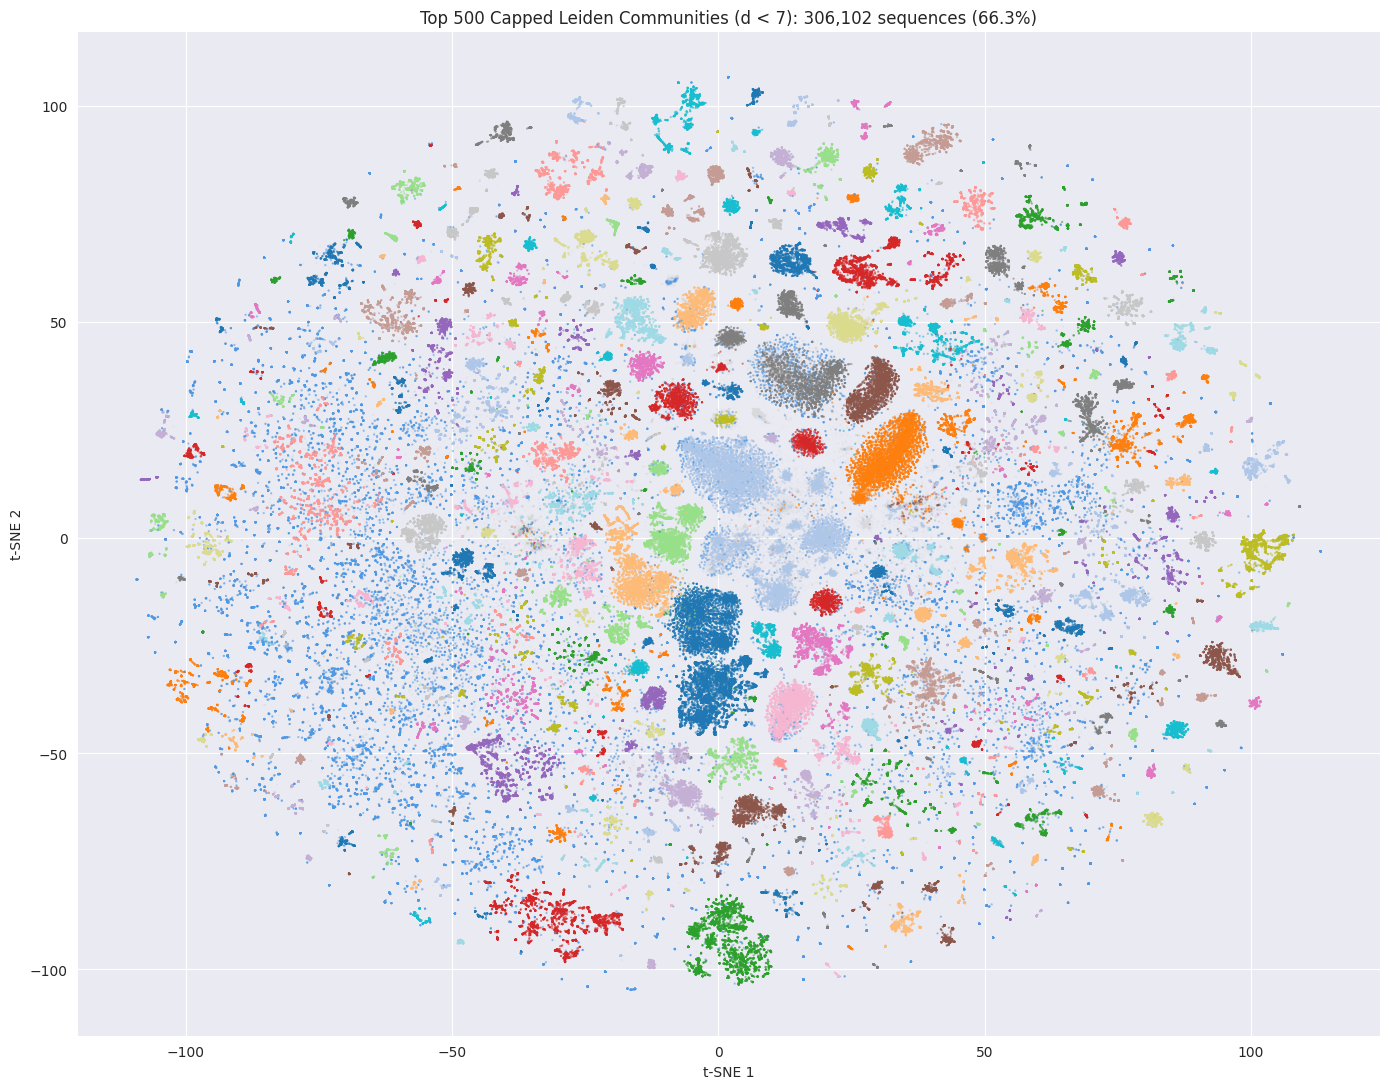

Top 500 communities cover 306,102 sequences (66.3% of total, 82.9% of clustered)
Smallest in top 500: 93


In [20]:
# Visualize top 500 communities on t-SNE (capped Leiden)
top_n = 500
top_comps_500 = np.argsort(-capped_sizes)[:top_n]
# Only keep communities with size > 1
top_comps_500 = top_comps_500[capped_sizes[top_comps_500] > 1]

comp_to_rank_500 = np.full(len(capped_sizes), -1, dtype = np.int32)
for rank, comp_id in enumerate(top_comps_500):
    comp_to_rank_500[comp_id] = rank
seq_rank_500 = comp_to_rank_500[capped_labels]

seq_comp_sizes = capped_sizes[capped_labels]
is_singleton = seq_comp_sizes == 1

# Use a cycling colormap — spatially separated so reuse is fine
cmap500 = plt.cm.get_cmap('tab20', 20)
colors = np.full((n_sequences, 4), [0.85, 0.85, 0.85, 0.08], dtype = np.float32)

# Non-singleton, outside top 500: light blue
other = (~is_singleton) & (seq_rank_500 == -1)
colors[other] = [0.3, 0.6, 0.9, 0.3]

# Top 500: cycle through 20 colors
for rank in range(len(top_comps_500)):
    mask = seq_rank_500 == rank
    colors[mask] = cmap500(rank % 20)
    colors[mask, 3] = 0.6

fig, ax = plt.subplots(figsize = (14, 11))
ax.scatter(tsne_result[is_singleton, 0], tsne_result[is_singleton, 1],
           c = colors[is_singleton], s = 0.05, rasterized = True)
fg = ~is_singleton
ax.scatter(tsne_result[fg, 0], tsne_result[fg, 1],
           c = colors[fg], s = 0.3, rasterized = True)

n_in_top = sum(capped_sizes[c] for c in top_comps_500)
n_clustered = capped_sizes[capped_sizes > 1].sum()
ax.set_xlabel('t-SNE 1')
ax.set_ylabel('t-SNE 2')
ax.set_title(f'Top {len(top_comps_500)} Capped Leiden Communities (d < 7): '
             f'{n_in_top:,} sequences ({100 * n_in_top / n_sequences:.1f}%)')
plt.tight_layout()
plt.show()

print(f'Top {len(top_comps_500)} communities cover {n_in_top:,} sequences '
      f'({100 * n_in_top / n_sequences:.1f}% of total, '
      f'{100 * n_in_top / n_clustered:.1f}% of clustered)')
print(f'Smallest in top {len(top_comps_500)}: {capped_sizes[top_comps_500[-1]]:,}')

Singletons: 29,738 (median length: 123,238 bp)
Clustered:  124,302 (median length: 172,932 bp)


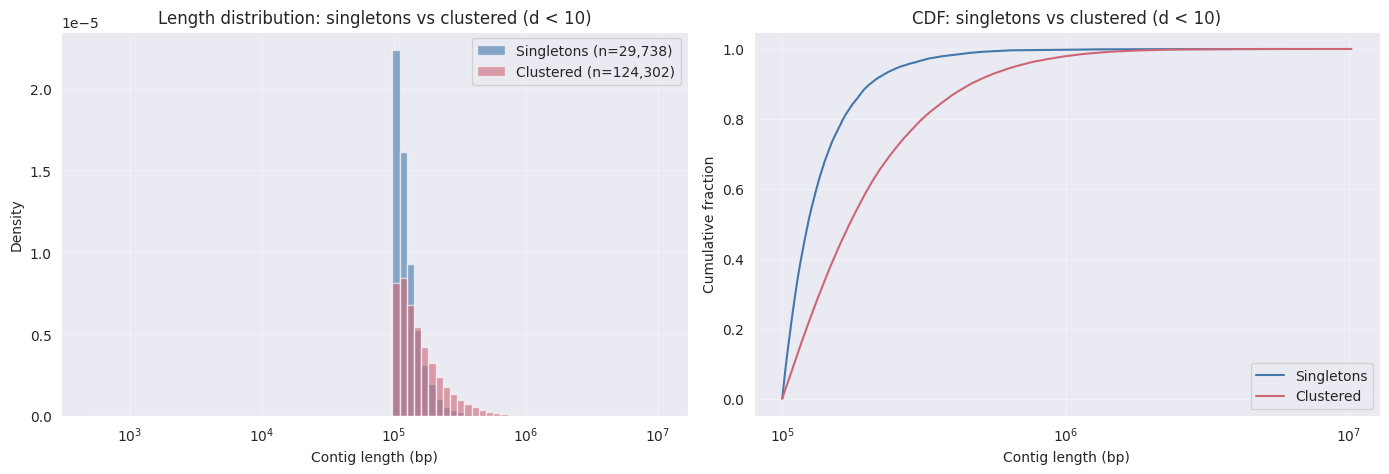

In [21]:
# Length distribution: singletons vs clustered at d < 10
# Uses component_labels and component_sizes from cell 22

seq_community_size = component_sizes[component_labels]
singleton_mask = seq_community_size == 1
clustered_mask = ~singleton_mask

lengths = kmers[:, 0]
singleton_lengths = lengths[singleton_mask]
clustered_lengths = lengths[clustered_mask]

print(f'Singletons: {singleton_mask.sum():,} (median length: {np.median(singleton_lengths):,.0f} bp)')
print(f'Clustered:  {clustered_mask.sum():,} (median length: {np.median(clustered_lengths):,.0f} bp)')

fig, axes = plt.subplots(1, 2, figsize = (14, 5))

# Left: overlapping histograms
bins = np.logspace(np.log10(500), np.log10(lengths.max()), 80)
axes[0].hist(singleton_lengths, bins = bins, alpha = 0.6,
             label = f'Singletons (n={singleton_mask.sum():,})', density = True, color = '#4477AA')
axes[0].hist(clustered_lengths, bins = bins, alpha = 0.6,
             label = f'Clustered (n={clustered_mask.sum():,})', density = True, color = '#CC6677')
axes[0].set_xscale('log')
axes[0].set_xlabel('Contig length (bp)')
axes[0].set_ylabel('Density')
axes[0].set_title('Length distribution: singletons vs clustered (d < 10)')
axes[0].legend()
axes[0].grid(True, alpha = 0.3)

# Right: CDFs
for data, label, color in [
    (singleton_lengths, 'Singletons', '#4477AA'),
    (clustered_lengths, 'Clustered', '#CC6677'),
]:
    sorted_d = np.sort(data)
    cdf = np.arange(1, len(sorted_d) + 1) / len(sorted_d)
    axes[1].plot(sorted_d, cdf, label = label, color = color, linewidth = 1.5)

axes[1].set_xscale('log')
axes[1].set_xlabel('Contig length (bp)')
axes[1].set_ylabel('Cumulative fraction')
axes[1].set_title('CDF: singletons vs clustered (d < 10)')
axes[1].legend()
axes[1].grid(True, alpha = 0.3)

plt.tight_layout()
plt.show()

/tmp/ipykernel_880065/2103436175.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', 20)


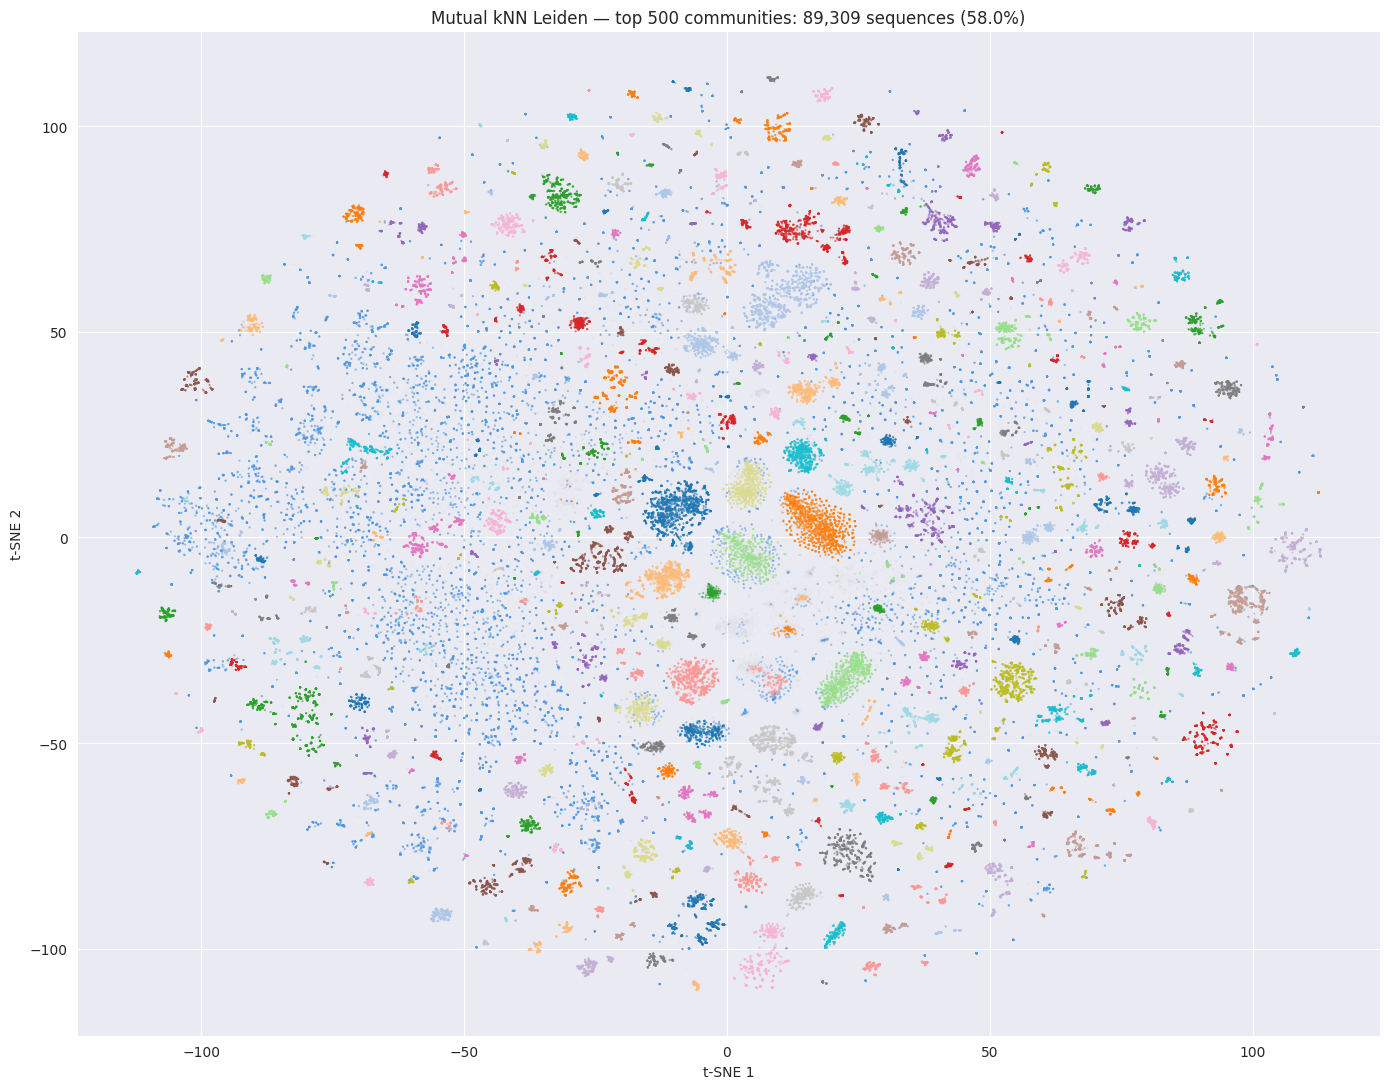

Top 500 communities cover 89,309 sequences (58.0% of total, 72.1% of clustered)
Smallest in top 500: 41


In [23]:
# Overlay mutual kNN Leiden communities on t-SNE
top_n = 500
top_comps = np.argsort(-component_sizes)[:top_n]
top_comps = top_comps[component_sizes[top_comps] > 1]

comp_to_rank = np.full(len(component_sizes), -1, dtype = np.int32)
for rank, comp_id in enumerate(top_comps):
    comp_to_rank[comp_id] = rank
seq_rank = comp_to_rank[component_labels]

seq_comp_sizes = component_sizes[component_labels]
is_singleton = seq_comp_sizes == 1

# Color scheme: grey singletons, light blue other clusters, cycling colors for top N
cmap = plt.cm.get_cmap('tab20', 20)
colors = np.full((n_sequences, 4), [0.85, 0.85, 0.85, 0.08], dtype = np.float32)

# Non-singleton, outside top N: light blue
other = (~is_singleton) & (seq_rank == -1)
colors[other] = [0.3, 0.6, 0.9, 0.3]

# Top N: cycle through 20 colors
for rank in range(len(top_comps)):
    mask = seq_rank == rank
    colors[mask] = cmap(rank % 20)
    colors[mask, 3] = 0.6

fig, ax = plt.subplots(figsize = (14, 11))

# Plot singletons first (background), then clustered (foreground)
ax.scatter(tsne_result[is_singleton, 0], tsne_result[is_singleton, 1],
           c = colors[is_singleton], s = 0.05, rasterized = True)
fg = ~is_singleton
ax.scatter(tsne_result[fg, 0], tsne_result[fg, 1],
           c = colors[fg], s = 0.3, rasterized = True)

n_in_top = sum(component_sizes[c] for c in top_comps)
ax.set_xlabel('t-SNE 1')
ax.set_ylabel('t-SNE 2')
ax.set_title(f'Mutual kNN Leiden — top {len(top_comps)} communities: '
             f'{n_in_top:,} sequences ({100 * n_in_top / n_sequences:.1f}%)')
plt.tight_layout()
plt.show()

print(f'Top {len(top_comps)} communities cover {n_in_top:,} sequences '
      f'({100 * n_in_top / n_sequences:.1f}% of total, '
      f'{100 * n_in_top / n_clustered:.1f}% of clustered)')
print(f'Smallest in top {len(top_comps)}: {component_sizes[top_comps[-1]]:,}')

In [21]:
# Save in-degree capped graph for MCL (ABC format: nodeA\tnodeB\tweight)
# Re-parses TSV and caps in-degree
from collections import defaultdict

d_threshold = 7.0
epsilon = 0.1
max_in_degree = 100
tsv_path = 'Runs/neighbors_SFE_SE_050.tsv'
n_sequences = len(embeddings)
out_path = 'Runs/graph_capped100_d7_50kbp.tsv'

id_to_idx = {id_: i for i, id_ in enumerate(embedding_ids)}

# Parse directed edges
print(f'Parsing edges with d < {d_threshold}...')
directed_edges = []
with open(tsv_path, 'r') as f:
    for i, line in enumerate(f):
        fields = line.rstrip('\n').split('\t')
        for field in fields[1:]:
            paren = field.rfind('(')
            dist = float(field[paren + 1:-1])
            if dist >= d_threshold:
                break
            j = id_to_idx[field[:paren]]
            directed_edges.append((i, j, dist))
        if (i + 1) % 1_000_000 == 0:
            print(f'  {i + 1:,} / {n_sequences:,}...')

print(f'Directed edges: {len(directed_edges):,}')

# Cap in-degree
incoming = defaultdict(list)
for i, j, dist in directed_edges:
    incoming[j].append((dist, i))

n_dropped = 0
n_written = 0
with open(out_path, 'w') as f:
    for j, sources in incoming.items():
        if len(sources) > max_in_degree:
            sources.sort()
            n_dropped += len(sources) - max_in_degree
            sources = sources[:max_in_degree]
        for dist, i in sources:
            weight = 1.0 / (dist + epsilon)
            f.write(f'{embedding_ids[i]}\t{embedding_ids[j]}\t{weight:.6f}\n')
            n_written += 1

del directed_edges, incoming

import os
size_mb = os.path.getsize(out_path) / 1e6
print(f'\nEdges dropped by capping: {n_dropped:,}')
print(f'Saved {n_written:,} edges to {out_path} ({size_mb:.1f} MB)')
print(f'Format: source_id<TAB>target_id<TAB>weight (ABC format for MCL)')

Parsing edges with d < 7.0...
Directed edges: 12,121,017

Edges dropped by capping: 4,181,328
Saved 7,939,689 edges to Runs/graph_capped100_d7_50kbp.tsv (311.9 MB)
Format: source_id<TAB>target_id<TAB>weight (ABC format for MCL)


In [5]:
# Pairwise distance / GC validation for in-degree capped Leiden (top 3)
# Uses component_labels/component_sizes from Cell 19 (in-degree capped)
rng_val = np.random.default_rng(42)
sorted_labels = np.argsort(-component_sizes)

for rank in range(3):
    label = sorted_labels[rank]
    comm_idx = np.where(component_labels == label)[0]
    size = component_sizes[label]
    n_sample = min(1000, size)

    if n_sample < size:
        sample_idx = rng_val.choice(comm_idx, size = n_sample, replace = False)
    else:
        sample_idx = comm_idx

    sample_emb = embeddings[sample_idx]
    sq_norms = np.einsum('ij,ij->i', sample_emb, sample_emb)
    sq_dists = sq_norms[:, None] + sq_norms[None, :] - 2 * (sample_emb @ sample_emb.T)
    np.maximum(sq_dists, 0, out = sq_dists)
    np.fill_diagonal(sq_dists, 0)
    d = np.sqrt(sq_dists[np.triu_indices(n_sample, k = 1)])

    gc = one_mers[comm_idx, 1]
    comm_lengths = lengths[comm_idx]

    print(f'Community #{rank + 1} (size {size:,}, sample {n_sample}):')
    print(f'  Distances: mean={d.mean():.2f}, std={d.std():.2f}, '
          f'median={np.median(d):.2f}, range={d.min():.2f}-{d.max():.2f}')
    print(f'  GC: mean={100 * gc.mean():.1f}%, std={100 * gc.std():.1f}%, '
          f'range={100 * gc.min():.1f}%-{100 * gc.max():.1f}%')
    print(f'  Length: mean={comm_lengths.mean() / 1000:.1f} kbp, '
          f'median={np.median(comm_lengths) / 1000:.1f} kbp, '
          f'range={comm_lengths.min() / 1000:.1f}-{comm_lengths.max() / 1000:.1f} kbp')
    print(f'  Ratio to global mean: {d.mean() / 18.70:.2f}')
    print()

    del sq_norms, sq_dists

Community #1 (size 55,965, sample 1000):
  Distances: mean=12.50, std=2.15, median=12.27, range=2.25-24.35
  GC: mean=62.7%, std=3.0%, range=47.1%-80.2%
  Length: mean=50.7 kbp, median=41.7 kbp, range=10.0-664.0 kbp
  Ratio to global mean: 0.67

Community #2 (size 31,430, sample 1000):
  Distances: mean=12.42, std=2.26, median=12.41, range=1.73-26.96
  GC: mean=28.7%, std=3.5%, range=20.4%-69.0%
  Length: mean=39.2 kbp, median=28.9 kbp, range=10.0-976.6 kbp
  Ratio to global mean: 0.66

Community #3 (size 28,049, sample 1000):
  Distances: mean=12.31, std=2.18, median=12.31, range=2.46-27.88
  GC: mean=57.9%, std=3.8%, range=30.3%-71.8%
  Length: mean=54.1 kbp, median=39.4 kbp, range=10.0-1951.0 kbp
  Ratio to global mean: 0.66



In [7]:
# In-degree capped Leiden at d=7, cap=100, weights=1/(d+0.1)
import igraph as ig
import leidenalg
from collections import defaultdict

d_threshold = 7.0
epsilon = 0.1
max_in_degree = 100
tsv_path = 'Runs/neighbors_SFE_SE_10.tsv'
n_sequences = len(embeddings)

id_to_idx = {id_: i for i, id_ in enumerate(embedding_ids)}

# Pass 1: collect all directed edges with distance < threshold
print(f'Building directed edge list with d < {d_threshold}...')
directed_edges = []

with open(tsv_path, 'r') as f:
    for i, line in enumerate(f):
        fields = line.rstrip('\n').split('\t')
        for field in fields[1:]:
            paren = field.rfind('(')
            dist = float(field[paren + 1:-1])
            if dist >= d_threshold:
                break
            j = id_to_idx[field[:paren]]
            directed_edges.append((i, j, dist))
        if (i + 1) % 1_000_000 == 0:
            print(f'  Parsed {i + 1:,} / {n_sequences:,}... ({len(directed_edges):,} edges)')

print(f'Total directed edges: {len(directed_edges):,}')

# Check max in-degree before capping
in_deg = defaultdict(int)
for _, j, _ in directed_edges:
    in_deg[j] += 1
max_orig = max(in_deg.values()) if in_deg else 0
print(f'Max in-degree before capping: {max_orig:,}')
del in_deg

# Pass 2: cap in-degree
print(f'Capping in-degree to {max_in_degree}...')
incoming = defaultdict(list)
for i, j, dist in directed_edges:
    incoming[j].append((dist, i))

capped_edges = []
capped_weights = []
n_dropped = 0

for j, sources in incoming.items():
    if len(sources) > max_in_degree:
        sources.sort()
        n_dropped += len(sources) - max_in_degree
        sources = sources[:max_in_degree]
    for dist, i in sources:
        capped_edges.append((i, j))
        capped_weights.append(1.0 / (dist + epsilon))

del directed_edges, incoming

print(f'Edges after capping: {len(capped_edges):,} (dropped {n_dropped:,})')

# Build igraph graph
print('Building igraph graph...')
g = ig.Graph(n = n_sequences, edges = capped_edges, directed = True)
g.es['weight'] = capped_weights
del capped_edges, capped_weights

g = g.as_undirected(mode = 'collapse', combine_edges = {'weight': 'max'})
print(f'Graph: {g.vcount():,} vertices, {g.ecount():,} edges')
w = np.array(g.es['weight'])
print(f'Weight range: {w.min():.4f} - {w.max():.4f}, mean: {w.mean():.4f}')

# Run Leiden with weights
print(f'Running Leiden (resolution=1.0, weighted, in-degree capped at {max_in_degree})...')
partition = leidenalg.find_partition(g, leidenalg.RBConfigurationVertexPartition,
                                     weights = 'weight', n_iterations = -1)
del g

capped7_labels = np.array(partition.membership)
capped7_sizes = np.bincount(capped7_labels)
n_components = len(capped7_sizes)
n_singletons = (capped7_sizes == 1).sum()
nonsingleton_sizes = np.sort(capped7_sizes[capped7_sizes > 1])[::-1]
n_clustered = capped7_sizes[capped7_sizes > 1].sum()

print(f'\n{"=" * 60}')
print(f'Leiden on in-degree capped graph (d < {d_threshold}, cap = {max_in_degree})')
print(f'{"=" * 60}')
print(f'Quality (modularity): {partition.quality():.4f}')
print(f'Total communities: {n_components:,}')
print(f'Singletons: {n_singletons:,} ({100 * n_singletons / n_sequences:.1f}%)')
print(f'Non-singleton communities: {len(nonsingleton_sizes):,}')
print(f'Clustered sequences: {n_clustered:,} ({100 * n_clustered / n_sequences:.1f}%)')
if len(nonsingleton_sizes) > 0:
    print(f'  Size range: {nonsingleton_sizes[-1]:,} - {nonsingleton_sizes[0]:,}')
    print(f'  Mean size: {nonsingleton_sizes.mean():.1f}')
    print(f'  Median size: {np.median(nonsingleton_sizes):.0f}')

print(f'\nTop 20 communities:')
for rank, size in enumerate(nonsingleton_sizes[:20]):
    print(f'  {rank + 1:3d}. {size:,} sequences')

# Pairwise distance / GC validation on top 3
print(f'\n{"=" * 60}')
print(f'Pairwise validation (top 3 communities)')
print(f'{"=" * 60}')
rng_val = np.random.default_rng(42)
sorted_labels = np.argsort(-capped7_sizes)

for rank in range(3):
    label = sorted_labels[rank]
    comm_idx = np.where(capped7_labels == label)[0]
    size = capped7_sizes[label]
    n_sample = min(1000, size)

    if n_sample < size:
        sample_idx = rng_val.choice(comm_idx, size = n_sample, replace = False)
    else:
        sample_idx = comm_idx

    sample_emb = embeddings[sample_idx]
    sq_norms = np.einsum('ij,ij->i', sample_emb, sample_emb)
    sq_dists = sq_norms[:, None] + sq_norms[None, :] - 2 * (sample_emb @ sample_emb.T)
    np.maximum(sq_dists, 0, out = sq_dists)
    np.fill_diagonal(sq_dists, 0)
    d = np.sqrt(sq_dists[np.triu_indices(n_sample, k = 1)])

    gc = one_mers[comm_idx, 1]
    comm_lengths = lengths[comm_idx]

    print(f'\nCommunity #{rank + 1} (size {size:,}, sample {n_sample}):')
    print(f'  Distances: mean={d.mean():.2f}, std={d.std():.2f}, '
          f'median={np.median(d):.2f}, range={d.min():.2f}-{d.max():.2f}')
    print(f'  GC: mean={100 * gc.mean():.1f}%, std={100 * gc.std():.1f}%, '
          f'range={100 * gc.min():.1f}%-{100 * gc.max():.1f}%')
    print(f'  Length: mean={comm_lengths.mean() / 1000:.1f} kbp, '
          f'median={np.median(comm_lengths) / 1000:.1f} kbp, '
          f'range={comm_lengths.min() / 1000:.1f}-{comm_lengths.max() / 1000:.1f} kbp')
    print(f'  Ratio to global mean: {d.mean() / 18.70:.2f}')

    del sq_norms, sq_dists

Building directed edge list with d < 7.0...
  Parsed 1,000,000 / 3,039,927... (4,534,024 edges)
  Parsed 2,000,000 / 3,039,927... (9,079,894 edges)
  Parsed 3,000,000 / 3,039,927... (13,608,081 edges)
Total directed edges: 13,789,958
Max in-degree before capping: 10,304
Capping in-degree to 100...
Edges after capping: 9,267,067 (dropped 4,522,891)
Building igraph graph...
Graph: 3,039,927 vertices, 6,744,130 edges
Weight range: 0.1408 - 10.0000, mean: 0.1949
Running Leiden (resolution=1.0, weighted, in-degree capped at 100)...

Leiden on in-degree capped graph (d < 7.0, cap = 100)
Quality (modularity): 2608341.2673
Total communities: 2,378,174
Singletons: 2,300,293 (75.7%)
Non-singleton communities: 77,881
Clustered sequences: 739,634 (24.3%)
  Size range: 2 - 13,968
  Mean size: 9.5
  Median size: 2

Top 20 communities:
    1. 13,968 sequences
    2. 11,120 sequences
    3. 10,613 sequences
    4. 8,430 sequences
    5. 8,172 sequences
    6. 7,490 sequences
    7. 7,233 sequences
   

In [8]:
# In-degree capped Leiden at d=5, cap=100, weights=1/(d+0.1)
import igraph as ig
import leidenalg
from collections import defaultdict

d_threshold = 5.0
epsilon = 0.1
max_in_degree = 100
tsv_path = 'Runs/neighbors_SFE_SE_10.tsv'
n_sequences = len(embeddings)

id_to_idx = {id_: i for i, id_ in enumerate(embedding_ids)}

# Pass 1: collect all directed edges with distance < threshold
print(f'Building directed edge list with d < {d_threshold}...')
directed_edges = []

with open(tsv_path, 'r') as f:
    for i, line in enumerate(f):
        fields = line.rstrip('\n').split('\t')
        for field in fields[1:]:
            paren = field.rfind('(')
            dist = float(field[paren + 1:-1])
            if dist >= d_threshold:
                break
            j = id_to_idx[field[:paren]]
            directed_edges.append((i, j, dist))
        if (i + 1) % 1_000_000 == 0:
            print(f'  Parsed {i + 1:,} / {n_sequences:,}... ({len(directed_edges):,} edges)')

print(f'Total directed edges: {len(directed_edges):,}')

# Check max in-degree before capping
in_deg = defaultdict(int)
for _, j, _ in directed_edges:
    in_deg[j] += 1
max_orig = max(in_deg.values()) if in_deg else 0
print(f'Max in-degree before capping: {max_orig:,}')
del in_deg

# Pass 2: cap in-degree
print(f'Capping in-degree to {max_in_degree}...')
incoming = defaultdict(list)
for i, j, dist in directed_edges:
    incoming[j].append((dist, i))

capped_edges = []
capped_weights = []
n_dropped = 0

for j, sources in incoming.items():
    if len(sources) > max_in_degree:
        sources.sort()
        n_dropped += len(sources) - max_in_degree
        sources = sources[:max_in_degree]
    for dist, i in sources:
        capped_edges.append((i, j))
        capped_weights.append(1.0 / (dist + epsilon))

del directed_edges, incoming

print(f'Edges after capping: {len(capped_edges):,} (dropped {n_dropped:,})')

# Build igraph graph
print('Building igraph graph...')
g = ig.Graph(n = n_sequences, edges = capped_edges, directed = True)
g.es['weight'] = capped_weights
del capped_edges, capped_weights

g = g.as_undirected(mode = 'collapse', combine_edges = {'weight': 'max'})
print(f'Graph: {g.vcount():,} vertices, {g.ecount():,} edges')
w = np.array(g.es['weight'])
print(f'Weight range: {w.min():.4f} - {w.max():.4f}, mean: {w.mean():.4f}')

# Run Leiden with weights
print(f'Running Leiden (resolution=1.0, weighted, in-degree capped at {max_in_degree})...')
partition = leidenalg.find_partition(g, leidenalg.RBConfigurationVertexPartition,
                                     weights = 'weight', n_iterations = -1)
del g

capped5_labels = np.array(partition.membership)
capped5_sizes = np.bincount(capped5_labels)
n_components = len(capped5_sizes)
n_singletons = (capped5_sizes == 1).sum()
nonsingleton_sizes = np.sort(capped5_sizes[capped5_sizes > 1])[::-1]
n_clustered = capped5_sizes[capped5_sizes > 1].sum()

print(f'\n{"=" * 60}')
print(f'Leiden on in-degree capped graph (d < {d_threshold}, cap = {max_in_degree})')
print(f'{"=" * 60}')
print(f'Quality (modularity): {partition.quality():.4f}')
print(f'Total communities: {n_components:,}')
print(f'Singletons: {n_singletons:,} ({100 * n_singletons / n_sequences:.1f}%)')
print(f'Non-singleton communities: {len(nonsingleton_sizes):,}')
print(f'Clustered sequences: {n_clustered:,} ({100 * n_clustered / n_sequences:.1f}%)')
if len(nonsingleton_sizes) > 0:
    print(f'  Size range: {nonsingleton_sizes[-1]:,} - {nonsingleton_sizes[0]:,}')
    print(f'  Mean size: {nonsingleton_sizes.mean():.1f}')
    print(f'  Median size: {np.median(nonsingleton_sizes):.0f}')

print(f'\nTop 20 communities:')
for rank, size in enumerate(nonsingleton_sizes[:20]):
    print(f'  {rank + 1:3d}. {size:,} sequences')

# Pairwise distance / GC validation on top 3
print(f'\n{"=" * 60}')
print(f'Pairwise validation (top 3 communities)')
print(f'{"=" * 60}')
rng_val = np.random.default_rng(42)
sorted_labels = np.argsort(-capped5_sizes)

for rank in range(3):
    label = sorted_labels[rank]
    comm_idx = np.where(capped5_labels == label)[0]
    size = capped5_sizes[label]
    n_sample = min(1000, size)

    if n_sample < size:
        sample_idx = rng_val.choice(comm_idx, size = n_sample, replace = False)
    else:
        sample_idx = comm_idx

    sample_emb = embeddings[sample_idx]
    sq_norms = np.einsum('ij,ij->i', sample_emb, sample_emb)
    sq_dists = sq_norms[:, None] + sq_norms[None, :] - 2 * (sample_emb @ sample_emb.T)
    np.maximum(sq_dists, 0, out = sq_dists)
    np.fill_diagonal(sq_dists, 0)
    d = np.sqrt(sq_dists[np.triu_indices(n_sample, k = 1)])

    gc = one_mers[comm_idx, 1]
    comm_lengths = lengths[comm_idx]

    print(f'\nCommunity #{rank + 1} (size {size:,}, sample {n_sample}):')
    print(f'  Distances: mean={d.mean():.2f}, std={d.std():.2f}, '
          f'median={np.median(d):.2f}, range={d.min():.2f}-{d.max():.2f}')
    print(f'  GC: mean={100 * gc.mean():.1f}%, std={100 * gc.std():.1f}%, '
          f'range={100 * gc.min():.1f}%-{100 * gc.max():.1f}%')
    print(f'  Length: mean={comm_lengths.mean() / 1000:.1f} kbp, '
          f'median={np.median(comm_lengths) / 1000:.1f} kbp, '
          f'range={comm_lengths.min() / 1000:.1f}-{comm_lengths.max() / 1000:.1f} kbp')
    print(f'  Ratio to global mean: {d.mean() / 18.70:.2f}')

    del sq_norms, sq_dists

Building directed edge list with d < 5.0...
  Parsed 1,000,000 / 3,039,927... (1,234,971 edges)
  Parsed 2,000,000 / 3,039,927... (2,468,001 edges)
  Parsed 3,000,000 / 3,039,927... (3,682,604 edges)
Total directed edges: 3,731,841
Max in-degree before capping: 1,541
Capping in-degree to 100...
Edges after capping: 3,230,777 (dropped 501,064)
Building igraph graph...
Graph: 3,039,927 vertices, 2,083,900 edges
Weight range: 0.1961 - 10.0000, mean: 0.2670
Running Leiden (resolution=1.0, weighted, in-degree capped at 100)...

Leiden on in-degree capped graph (d < 5.0, cap = 100)
Quality (modularity): 1108103.2906
Total communities: 2,748,027
Singletons: 2,685,223 (88.3%)
Non-singleton communities: 62,804
Clustered sequences: 354,704 (11.7%)
  Size range: 2 - 5,620
  Mean size: 5.6
  Median size: 2

Top 20 communities:
    1. 5,620 sequences
    2. 2,986 sequences
    3. 2,738 sequences
    4. 2,213 sequences
    5. 1,979 sequences
    6. 1,835 sequences
    7. 1,623 sequences
    8. 1,550

In [22]:
# MCL pairwise GC validation across inflation values (50 kbp data, d=7)
# MCL output files: one cluster per line, tab-separated member IDs
rng_val = np.random.default_rng(42)

mcl_dir = 'Runs/MCL_50kbp_d7'
inflations = [1.4, 2.0, 3.0, 4.0, 5.0, 6.0]

for infl in inflations:
    mcl_file = f'{mcl_dir}/mcl_I{infl}.clusters'
    print(f'{"=" * 70}')
    print(f'MCL I={infl}')
    print(f'{"=" * 70}')

    mcl_clusters = []
    with open(mcl_file) as f:
        for line in f:
            members = line.rstrip('\n').split('\t')
            if len(members) > 1:
                indices = np.array([id_to_idx[m] for m in members])
                mcl_clusters.append(indices)

    mcl_clusters.sort(key = len, reverse = True)
    print(f'Non-singleton clusters: {len(mcl_clusters):,}')
    print(f'Top 5 sizes: {[len(c) for c in mcl_clusters[:5]]}')
    print()

    for rank in range(3):
        comm_idx = mcl_clusters[rank]
        size = len(comm_idx)
        n_sample = min(1000, size)

        if n_sample < size:
            sample_idx = rng_val.choice(comm_idx, size = n_sample, replace = False)
        else:
            sample_idx = comm_idx

        sample_emb = embeddings[sample_idx]
        sq_norms = np.einsum('ij,ij->i', sample_emb, sample_emb)
        sq_dists = sq_norms[:, None] + sq_norms[None, :] - 2 * (sample_emb @ sample_emb.T)
        np.maximum(sq_dists, 0, out = sq_dists)
        np.fill_diagonal(sq_dists, 0)
        d = np.sqrt(sq_dists[np.triu_indices(n_sample, k = 1)])

        gc = one_mers[comm_idx, 1]
        comm_lengths = lengths[comm_idx]

        gc_span = 100 * (gc.max() - gc.min())
        print(f'  Community #{rank + 1} (size {size:,}, sample {n_sample}):')
        print(f'    Distances: mean={d.mean():.2f}, median={np.median(d):.2f}, '
              f'range={d.min():.2f}-{d.max():.2f}')
        print(f'    GC: mean={100 * gc.mean():.1f}%, std={100 * gc.std():.1f}%, '
              f'range={100 * gc.min():.1f}%-{100 * gc.max():.1f}% (span {gc_span:.0f} pp)')
        print(f'    Length: mean={comm_lengths.mean() / 1000:.1f} kbp, '
              f'range={comm_lengths.min() / 1000:.1f}-{comm_lengths.max() / 1000:.1f} kbp')
        print()

        del sq_norms, sq_dists

MCL I=1.4
Non-singleton clusters: 17,685
Top 5 sizes: [1702, 1614, 1604, 1568, 1550]

  Community #1 (size 1,702, sample 1000):
    Distances: mean=6.98, median=7.02, range=1.03-11.06
    GC: mean=60.6%, std=1.4%, range=53.2%-66.1% (span 13 pp)
    Length: mean=115.4 kbp, range=50.0-1281.9 kbp

  Community #2 (size 1,614, sample 1000):
    Distances: mean=7.26, median=7.33, range=0.99-12.09
    GC: mean=45.8%, std=1.1%, range=37.0%-49.9% (span 13 pp)
    Length: mean=143.0 kbp, range=50.0-1497.0 kbp

  Community #3 (size 1,604, sample 1000):
    Distances: mean=8.16, median=8.13, range=2.05-15.03
    GC: mean=54.8%, std=1.1%, range=48.9%-61.4% (span 13 pp)
    Length: mean=122.1 kbp, range=50.0-1063.2 kbp

MCL I=2.0
Non-singleton clusters: 27,475
Top 5 sizes: [364, 363, 323, 317, 315]

  Community #1 (size 364, sample 364):
    Distances: mean=6.63, median=6.67, range=1.57-10.18
    GC: mean=52.7%, std=1.4%, range=48.5%-57.6% (span 9 pp)
    Length: mean=118.5 kbp, range=50.3-642.7 kbp

In [ ]:
# t-SNE overlay of MCL communities (I=2.0, 100 kbp data, d=5)
import os

mcl_file = 'Runs/MCL_100kbp_d5/mcl_I2.0.clusters'
id_to_idx = {id_: i for i, id_ in enumerate(embedding_ids)}

# Parse MCL clusters
mcl_clusters = []
with open(mcl_file) as f:
    for line in f:
        members = line.rstrip('\n').split('\t')
        if len(members) > 1:
            indices = np.array([id_to_idx[m] for m in members])
            mcl_clusters.append(indices)

mcl_clusters.sort(key = len, reverse = True)
print(f'Non-singleton clusters: {len(mcl_clusters):,}')
print(f'Top 20 sizes: {[len(c) for c in mcl_clusters[:20]]}')

# Assign labels: -1 = singleton/unclustered, 0-based for top N
n_top = 20
mcl_overlay = np.full(len(embeddings), -1, dtype = np.int32)
for rank, comm_idx in enumerate(mcl_clusters[:n_top]):
    mcl_overlay[comm_idx] = rank

# Also mark non-top communities as -2 (light blue)
for comm_idx in mcl_clusters[n_top:]:
    mcl_overlay[comm_idx] = -2

n_top_seqs = sum(len(c) for c in mcl_clusters[:n_top])
n_other = sum(len(c) for c in mcl_clusters[n_top:])
n_sing = (mcl_overlay == -1).sum()
print(f'Top {n_top}: {n_top_seqs:,} seqs | Other clusters: {n_other:,} | Singletons: {n_sing:,}')

# Plot
fig, ax = plt.subplots(figsize = (14, 12))

# Grey singletons
mask_sing = mcl_overlay == -1
ax.scatter(tsne_result[mask_sing, 0], tsne_result[mask_sing, 1],
           c = '#CCCCCC', s = 0.3, alpha = 0.2, rasterized = True)

# Light blue for non-top communities
mask_other = mcl_overlay == -2
ax.scatter(tsne_result[mask_other, 0], tsne_result[mask_other, 1],
           c = '#87CEEB', s = 0.5, alpha = 0.3, rasterized = True)

# Top N communities in distinct colors
colors = plt.cm.tab20(np.linspace(0, 1, n_top))
for rank in range(n_top):
    mask = mcl_overlay == rank
    ax.scatter(tsne_result[mask, 0], tsne_result[mask, 1],
               c = [colors[rank]], s = 1.5, alpha = 0.7, rasterized = True,
               label = f'#{rank + 1} ({len(mcl_clusters[rank])})')

ax.set_xlabel('t-SNE 1')
ax.set_ylabel('t-SNE 2')
ax.set_title(f'MCL I=2.0 communities on t-SNE (top {n_top}, 100 kbp, d=5)')
ax.legend(loc = 'upper right', fontsize = 7, markerscale = 5, ncol = 2)
plt.tight_layout()
plt.savefig('Runs/mcl_tsne_I2.0_100kbp_d5.png', dpi = 150, bbox_inches = 'tight')
plt.show()
print(f'Saved to Runs/mcl_tsne_I2.0_100kbp_d5.png')

Loading full dataset...
Loaded 6,693,829 sequences (384d) in 1.8s
    3 kbp: n= 5,951,176 | mean=12.76  median=12.28 | IQR=[8.12, 17.09] | nn1<5: 9.5% | 143.7s
    5 kbp: n= 4,776,770 | mean=11.43  median=11.17 | IQR=[7.76, 14.99] | nn1<5: 10.0% | 117.0s
   10 kbp: n= 3,039,927 | mean=9.27  median=9.20 | IQR=[6.58, 11.91] | nn1<5: 13.8% | 75.9s
   20 kbp: n= 1,556,556 | mean=7.11  median=7.02 | IQR=[5.02, 8.96] | nn1<5: 24.8% | 39.2s
   50 kbp: n=   461,674 | mean=4.99  median=4.82 | IQR=[3.39, 6.29] | nn1<5: 53.4% | 12.1s
  100 kbp: n=   154,040 | mean=3.58  median=3.38 | IQR=[2.24, 4.56] | nn1<5: 81.6% | 4.2s
  200 kbp: n=    53,138 | mean=2.64  median=2.36 | IQR=[1.55, 3.32] | nn1<5: 92.8% | 1.8s
  500 kbp: n=    11,006 | mean=2.08  median=1.70 | IQR=[1.01, 2.55] | nn1<5: 93.4% | 0.5s


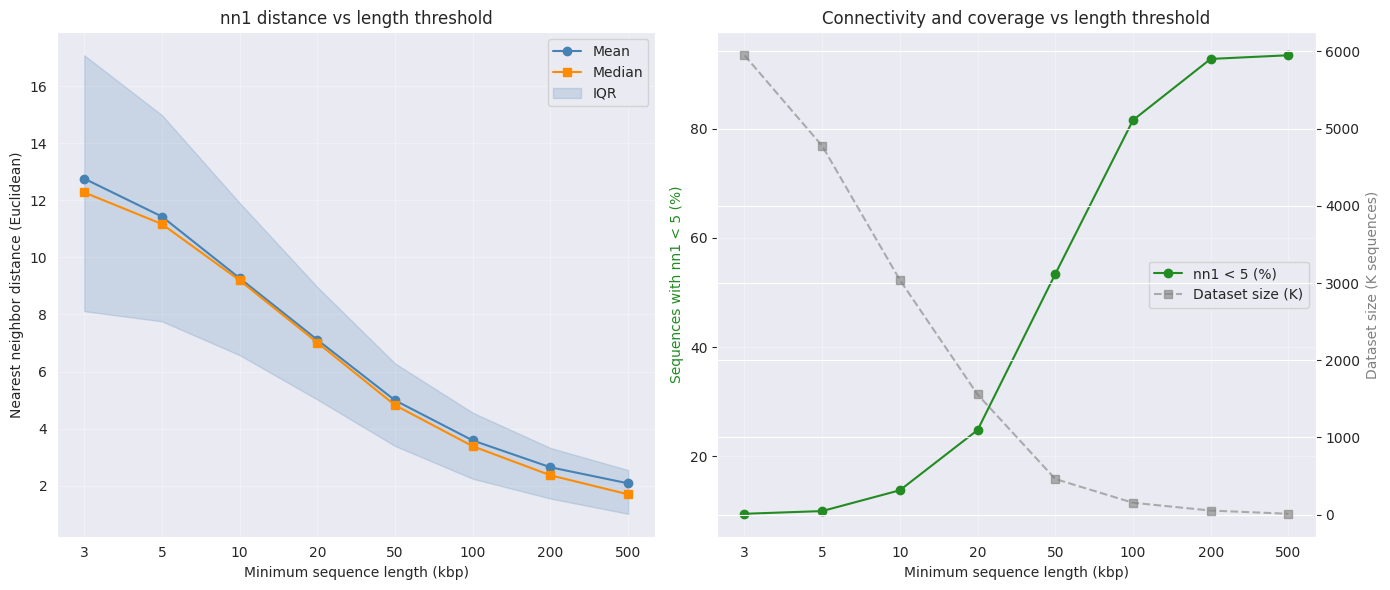


Saved to Runs/nn1_vs_length_threshold.png


In [32]:
# Length threshold sweep: nn1 statistics by minimum sequence length
# Self-contained — loads full dataset independently of earlier cells
import numpy as np
import matplotlib.pyplot as plt
import time

print('Loading full dataset...')
t0 = time.time()
full_data = np.load('Runs/embeddings_SFE_SE_1.npy')
full_lengths = full_data[:, 0]
full_emb = full_data[:, 1:].astype(np.float32)
del full_data
print(f'Loaded {len(full_emb):,} sequences ({full_emb.shape[1]}d) in {time.time() - t0:.1f}s')

thresholds = [3_000, 5_000, 10_000, 20_000, 50_000, 100_000, 200_000, 500_000]
n_queries = 10_000
q_batch = 500
c_batch = 200_000
rng = np.random.default_rng(42)

all_results = []

for thresh in thresholds:
    t0 = time.time()
    indices = np.where(full_lengths >= thresh)[0]
    n = len(indices)

    if n < 100:
        print(f'\n{thresh / 1000:.0f} kbp: {n} sequences — skipping')
        continue

    n_q = min(n_queries, n)
    q_pos = rng.choice(n, size = n_q, replace = False)
    q_global = indices[q_pos]

    min_dists = np.full(n_q, np.inf, dtype = np.float32)

    for qi in range(0, n_q, q_batch):
        qe = min(qi + q_batch, n_q)
        q_emb = full_emb[q_global[qi:qe]]
        q_norms = np.einsum('ij,ij->i', q_emb, q_emb)

        for ci in range(0, n, c_batch):
            ce = min(ci + c_batch, n)
            c_global = indices[ci:ce]
            c_emb = full_emb[c_global]
            c_norms = np.einsum('ij,ij->i', c_emb, c_emb)

            sq_dists = q_norms[:, None] + c_norms[None, :] - 2 * (q_emb @ c_emb.T)
            np.maximum(sq_dists, 0, out = sq_dists)

            # Mask self-distances
            for i in range(qe - qi):
                g = q_global[qi + i]
                local = np.searchsorted(c_global, g)
                if local < len(c_global) and c_global[local] == g:
                    sq_dists[i, local] = np.inf

            chunk_min = np.sqrt(sq_dists.min(axis = 1))
            min_dists[qi:qe] = np.minimum(min_dists[qi:qe], chunk_min)

    elapsed = time.time() - t0

    r = {
        'thresh': thresh,
        'n_total': n,
        'mean': float(min_dists.mean()),
        'median': float(np.median(min_dists)),
        'p25': float(np.percentile(min_dists, 25)),
        'p75': float(np.percentile(min_dists, 75)),
        'frac_lt5': float((min_dists < 5).mean()),
    }
    all_results.append(r)

    print(f'{thresh / 1000:>5.0f} kbp: n={n:>10,} | '
          f'mean={r["mean"]:.2f}  median={r["median"]:.2f} | '
          f'IQR=[{r["p25"]:.2f}, {r["p75"]:.2f}] | '
          f'nn1<5: {r["frac_lt5"]:.1%} | {elapsed:.1f}s')

# --- Plot ---
fig, axes = plt.subplots(1, 2, figsize = (14, 6))

labels = [f'{r["thresh"] / 1000:.0f}' for r in all_results]
means = [r['mean'] for r in all_results]
medians = [r['median'] for r in all_results]
p25s = [r['p25'] for r in all_results]
p75s = [r['p75'] for r in all_results]
frac5 = [100 * r['frac_lt5'] for r in all_results]
sizes = [r['n_total'] / 1000 for r in all_results]
x = range(len(labels))

# Left: nn1 distance vs threshold
ax = axes[0]
ax.plot(x, means, 'o-', label = 'Mean', color = 'steelblue')
ax.plot(x, medians, 's-', label = 'Median', color = 'darkorange')
ax.fill_between(x, p25s, p75s, alpha = 0.2, color = 'steelblue', label = 'IQR')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_xlabel('Minimum sequence length (kbp)')
ax.set_ylabel('Nearest neighbor distance (Euclidean)')
ax.set_title('nn1 distance vs length threshold')
ax.legend()
ax.grid(True, alpha = 0.3)

# Right: connectivity and coverage
ax = axes[1]
ax2 = ax.twinx()
ln1 = ax.plot(x, frac5, 'o-', label = 'nn1 < 5 (%)', color = 'forestgreen')
ln2 = ax2.plot(x, sizes, 's--', label = 'Dataset size (K)', color = 'gray', alpha = 0.6)
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_xlabel('Minimum sequence length (kbp)')
ax.set_ylabel('Sequences with nn1 < 5 (%)', color = 'forestgreen')
ax2.set_ylabel('Dataset size (K sequences)', color = 'gray')
ax.set_title('Connectivity and coverage vs length threshold')
lns = ln1 + ln2
ax.legend(lns, [l.get_label() for l in lns], loc = 'center right')
ax.grid(True, alpha = 0.3)

plt.tight_layout()
plt.savefig('Runs/nn1_vs_length_threshold.png', dpi = 150, bbox_inches = 'tight')
plt.show()
print(f'\nSaved to Runs/nn1_vs_length_threshold.png')